# INN Hotels Project

## Context

A significant number of hotel bookings are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. Such losses are particularly high on last-minute cancellations.

The new technologies involving online booking channels have dramatically changed customers’ booking possibilities and behavior. This adds a further dimension to the challenge of how hotels handle cancellations, which are no longer limited to traditional booking and guest characteristics.

The cancellation of bookings impact a hotel on various fronts:
* Loss of resources (revenue) when the hotel cannot resell the room.
* Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms.
* Lowering prices last minute, so the hotel can resell a room, resulting in reducing the profit margin.
* Human resources to make arrangements for the guests.

## Objective
The increasing number of cancellations calls for a Machine Learning based solution that can help in predicting which booking is likely to be canceled. INN Hotels Group has a chain of hotels in Portugal, they are facing problems with the high number of booking cancellations and have reached out to your firm for data-driven solutions. You as a data scientist have to analyze the data provided to find which factors have a high influence on booking cancellations, build a predictive model that can predict which booking is going to be canceled in advance, and help in formulating profitable policies for cancellations and refunds.

## Data Description
The data contains the different attributes of customers' booking details. The detailed data dictionary is given below.


**Data Dictionary**

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
    * Not Selected – No meal plan selected
    * Meal Plan 1 – Breakfast
    * Meal Plan 2 – Half board (breakfast and one other meal)
    * Meal Plan 3 – Full board (breakfast, lunch, and dinner)
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

## Importing necessary libraries and data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Installing the libraries with the specified version.
!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 statsmodels==0.14.1 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

from sklearn.model_selection import train_test_split

import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INNHotelsGroup.csv')
df = data.copy()

## Data Overview

- Observations
- Sanity checks

In [ ]:
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0            65.00000   
1                                     0           106.68000   
2                                     0            60.00000   
3                                     0           100.00000   
4                                     0            94.50000   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [ ]:
df.tail()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
36270   INN36271             3               0                     2   
36271   INN36272             2               0                     1   
36272   INN36273             2               0                     2   
36273   INN36274             2               0                     0   
36274   INN36275             2               0                     1   

       no_of_week_nights type_of_meal_plan  required_car_parking_space  \
36270                  6       Meal Plan 1                           0   
36271                  3       Meal Plan 1                           0   
36272                  6       Meal Plan 1                           0   
36273                  3      Not Selected                           0   
36274                  2       Meal Plan 1                           0   

      room_type_reserved  lead_time  arrival_year  arrival_month  \
36270        Room_Type 4         85          2018              8   
36271        Room_Type 1        228          2018             10   
36272        Room_Type 1        148          2018              7   
36273        Room_Type 1         63          2018              4   
36274        Room_Type 1        207          2018             12   

       arrival_date market_segment_type  repeated_guest  \
36270             3              Online               0   
36271            17              Online               0   
36272             1              Online               0   
36273            21              Online               0   
36274            30             Offline               0   

       no_of_previous_cancellations  no_of_previous_bookings_not_canceled  \
36270                             0                                     0   
36271                             0                                     0   
36272                             0                                     0   
36273                             0                                     0   
36274                             0                                     0   

       avg_price_per_room  no_of_special_requests booking_status  
36270           167.80000                       1   Not_Canceled  
36271            90.95000                       2       Canceled  
36272            98.39000                       2   Not_Canceled  
36273            94.50000                       0       Canceled  
36274           161.67000                       0   Not_Canceled

In [ ]:
df.shape

(36275, 19)

* There are 36,275 rows and 19 columns in this dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

* There are 14 numeric and 5 string columns in this dataset.
* The target variable is the booking status, which in a object data type.

In [ ]:
df.describe(include='all')

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
count       36275   36275.00000     36275.00000           36275.00000   
unique      36275           NaN             NaN                   NaN   
top      INN00001           NaN             NaN                   NaN   
freq            1           NaN             NaN                   NaN   
mean          NaN       1.84496         0.10528               0.81072   
std           NaN       0.51871         0.40265               0.87064   
min           NaN       0.00000         0.00000               0.00000   
25%           NaN       2.00000         0.00000               0.00000   
50%           NaN       2.00000         0.00000               1.00000   
75%           NaN       2.00000         0.00000               2.00000   
max           NaN       4.00000        10.00000               7.00000   

        no_of_week_nights type_of_meal_plan  required_car_parking_space  \
count         36275.00000             36275                 36275.00000   
unique                NaN                 4                         NaN   
top                   NaN       Meal Plan 1                         NaN   
freq                  NaN             27835                         NaN   
mean              2.20430               NaN                     0.03099   
std               1.41090               NaN                     0.17328   
min               0.00000               NaN                     0.00000   
25%               1.00000               NaN                     0.00000   
50%               2.00000               NaN                     0.00000   
75%               3.00000               NaN                     0.00000   
max              17.00000               NaN                     1.00000   

       room_type_reserved   lead_time  arrival_year  arrival_month  \
count               36275 36275.00000   36275.00000    36275.00000   
unique                  7         NaN           NaN            NaN   
top           Room_Type 1         NaN           NaN            NaN   
freq                28130         NaN           NaN            NaN   
mean                  NaN    85.23256    2017.82043        7.42365   
std                   NaN    85.93082       0.38384        3.06989   
min                   NaN     0.00000    2017.00000        1.00000   
25%                   NaN    17.00000    2018.00000        5.00000   
50%                   NaN    57.00000    2018.00000        8.00000   
75%                   NaN   126.00000    2018.00000       10.00000   
max                   NaN   443.00000    2018.00000       12.00000   

        arrival_date market_segment_type  repeated_guest  \
count    36275.00000               36275     36275.00000   
unique           NaN                   5             NaN   
top              NaN              Online             NaN   
freq             NaN               23214             NaN   
mean        15.59700                 NaN         0.02564   
std          8.74045                 NaN         0.15805   
min          1.00000                 NaN         0.00000   
25%          8.00000                 NaN         0.00000   
50%         16.00000                 NaN         0.00000   
75%         23.00000                 NaN         0.00000   
max         31.00000                 NaN         1.00000   

        no_of_previous_cancellations  no_of_previous_bookings_not_canceled  \
count                    36275.00000                           36275.00000   
unique                           NaN                                   NaN   
top                              NaN                                   NaN   
freq                             NaN                                   NaN   
mean                         0.02335                               0.15341   
std                          0.36833                               1.75417   
min                          0.00000                               0.00000   
25%                          0.00000       

In [ ]:
df.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

* There are no missing values in the dataset.

In [ ]:
df.duplicated().sum()

0

* There are no duplicated values in the dataset.

In [ ]:
df.drop('Booking_ID', axis=1)

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0                 2               0                     1                  2   
1                 2               0                     2                  3   
2                 1               0                     2                  1   
3                 2               0                     0                  2   
4                 2               0                     1                  1   
...             ...             ...                   ...                ...   
36270             3               0                     2                  6   
36271             2               0                     1                  3   
36272             2               0                     2                  6   
36273             2               0                     0                  3   
36274             2               0                     1                  2   

      type_of_meal_plan  required_car_parking_space room_type_reserved  \
0           Meal Plan 1                           0        Room_Type 1   
1          Not Selected                           0        Room_Type 1   
2           Meal Plan 1                           0        Room_Type 1   
3           Meal Plan 1                           0        Room_Type 1   
4          Not Selected                           0        Room_Type 1   
...                 ...                         ...                ...   
36270       Meal Plan 1                           0        Room_Type 4   
36271       Meal Plan 1                           0        Room_Type 1   
36272       Meal Plan 1                           0        Room_Type 1   
36273      Not Selected                           0        Room_Type 1   
36274       Meal Plan 1                           0        Room_Type 1   

       lead_time  arrival_year  arrival_month  arrival_date  \
0            224          2017             10             2   
1              5          2018             11             6   
2              1          2018              2            28   
3            211          2018              5            20   
4             48          2018              4            11   
...          ...           ...            ...           ...   
36270         85          2018              8             3   
36271        228          2018             10            17   
36272        148          2018              7             1   
36273         63          2018              4            21   
36274        207          2018             12            30   

      market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                 Offline               0                             0   
1                  Online               0                             0   
2                  Online               0                             0   
3                  Online               0                             0   
4                  Online               0                             0   
...                   ...             ...                           ...   
36270              Online               0                             0   
36271              Online               0                             0   
36272              Online               0                             0   
36273              Online               0                             0   
36274             Offline               0                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                         0            65.00000   
1                                         0           106.68000   
2                                         0            60.00000   
3                                         0           100.00000   
4                                         0            94.50000   
...                                     ...                 ...   
36270                         

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What are the busiest months in the hotel?
2. Which market segment do most of the guests come from?
3. Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?
4. What percentage of bookings are canceled?
5. Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
6. Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?

In [ ]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )

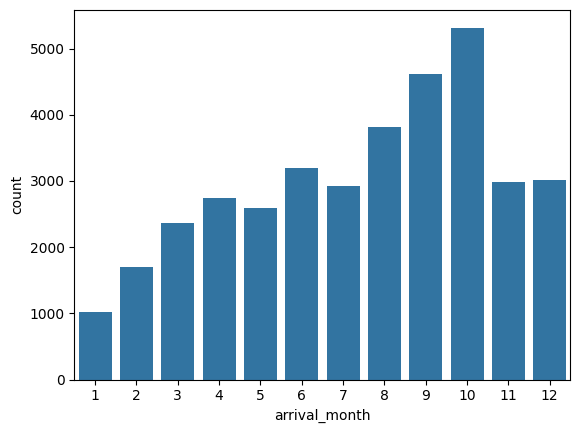

In [ ]:
sns.countplot(x='arrival_month', data=df)
plt.show()

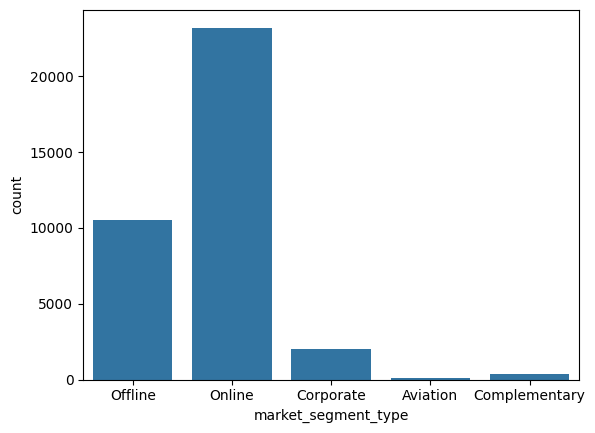

In [ ]:
sns.countplot(x='market_segment_type', data=df)
plt.show()

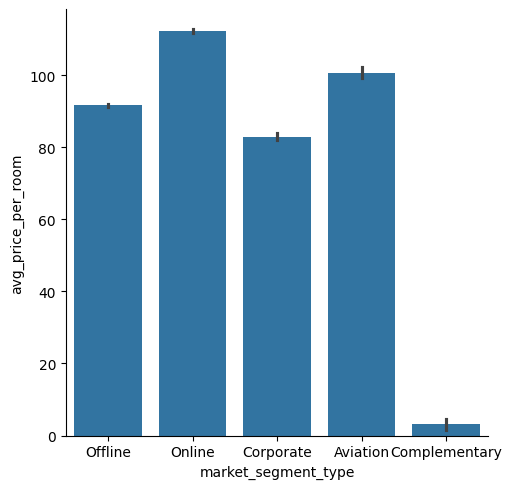

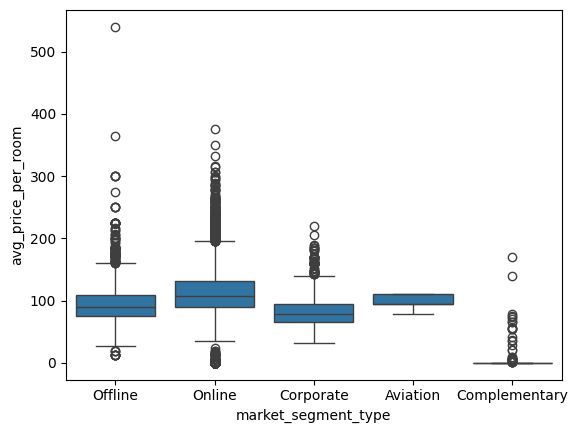

In [ ]:
sns.catplot(x='market_segment_type', y='avg_price_per_room', data=df, kind='bar')
plt.show()
sns.boxplot(x='market_segment_type', y='avg_price_per_room', data=df)
plt.show()

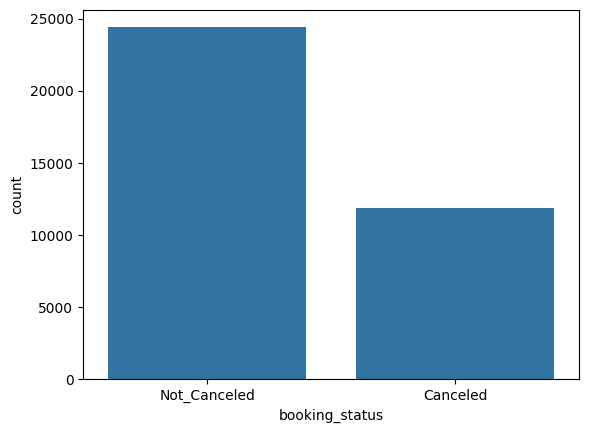

In [ ]:
sns.countplot(x='booking_status', data=df)
plt.show()

In [ ]:
total_bookings = df.shape[0]
canceled_bookings = df[df['booking_status'] == 'Canceled'].shape[0]
percent_canceled = (canceled_bookings / total_bookings) * 100
print(f"Percentage of bookings that are Canceled: {percent_canceled:.2f}%")

Percentage of bookings that are Canceled: 32.76%


In [ ]:
frequent_visitor = df[df['repeated_guest'] == 1]
frequent_visitor_canceled = frequent_visitor[frequent_visitor['booking_status'] == 'Canceled'].shape[0]
percent_frequent_visitor_canceled = (frequent_visitor_canceled / len(frequent_visitor)) * 100
print(f"Percentage of repeated guests who cancel: {percent_frequent_visitor_canceled:.2f}%")

Percentage of repeated guests who cancel: 1.72%


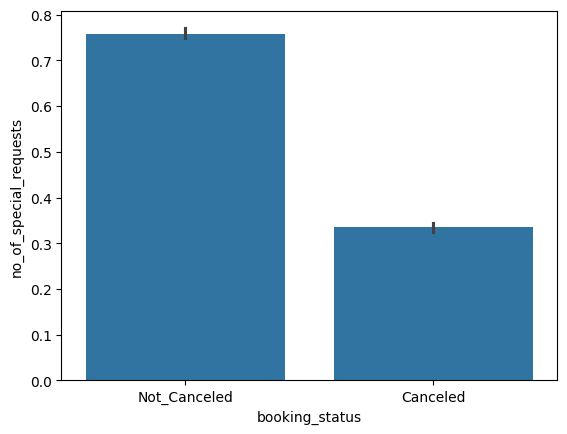

In [ ]:
sns.barplot(x='booking_status', y='no_of_special_requests', data=df)
plt.show()

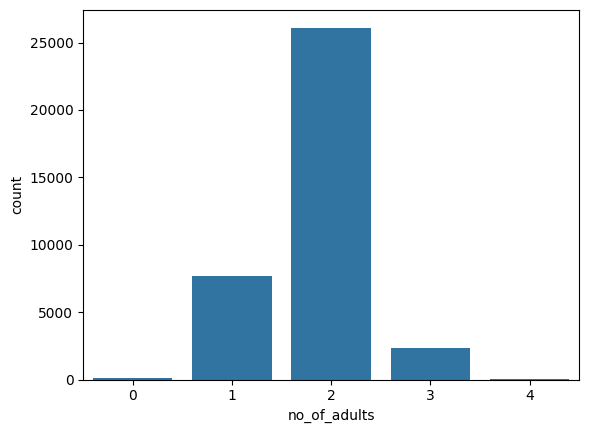

In [ ]:
sns.countplot(x='no_of_adults', data=df)
plt.show()

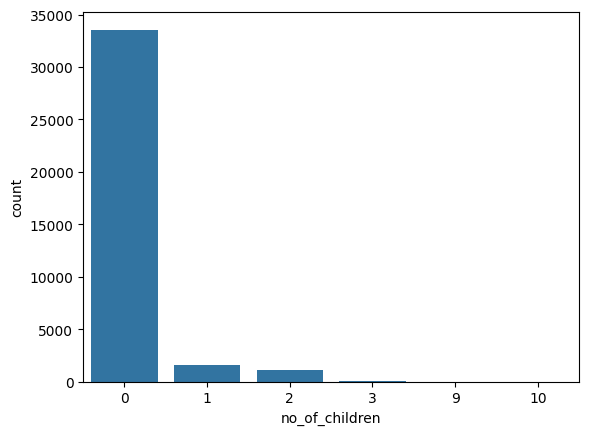

In [ ]:
sns.countplot(x='no_of_children', data=df)
plt.show()

In [ ]:
no_of_people = df['no_of_adults'] + df['no_of_children']

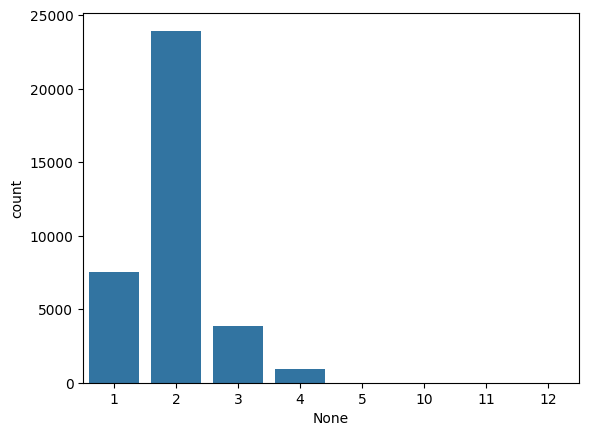

In [ ]:
sns.countplot(x=no_of_people, data=df)
plt.show()

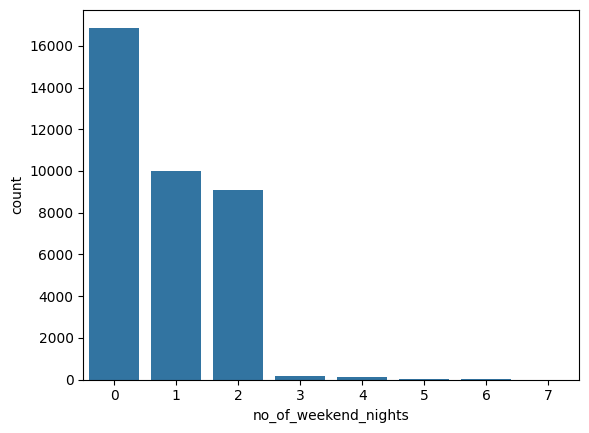

In [ ]:
sns.countplot(x='no_of_weekend_nights', data=df)
plt.show()

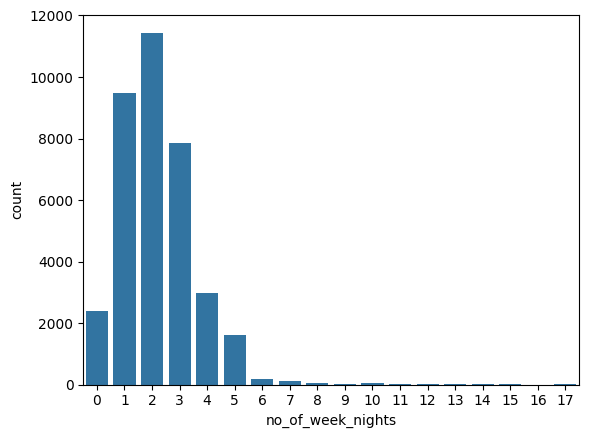

In [ ]:
sns.countplot(x='no_of_week_nights', data=df)
plt.show()

In [ ]:
total_days = df['no_of_weekend_nights'] + df['no_of_week_nights']

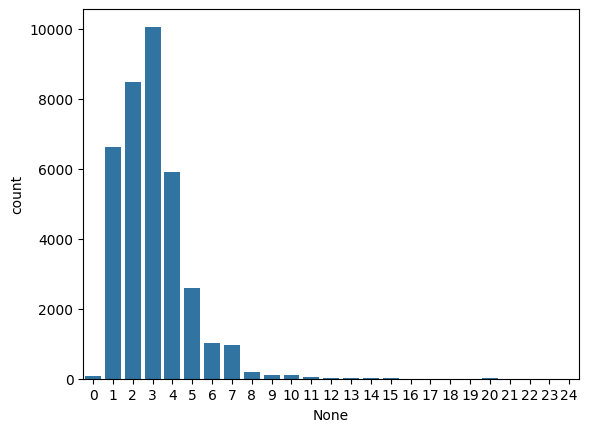

In [ ]:
sns.countplot(x=total_days, data=df)
plt.show()

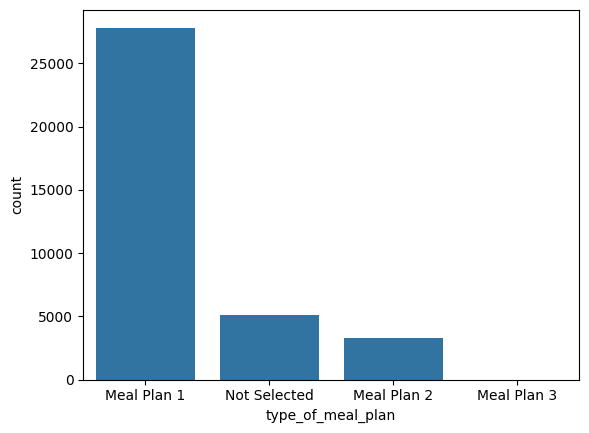

In [ ]:
sns.countplot(x='type_of_meal_plan', data=df)
plt.show()

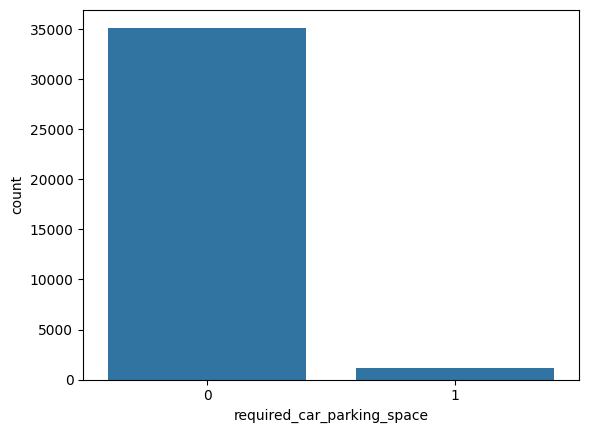

In [ ]:
sns.countplot(x='required_car_parking_space', data=df)
plt.show()

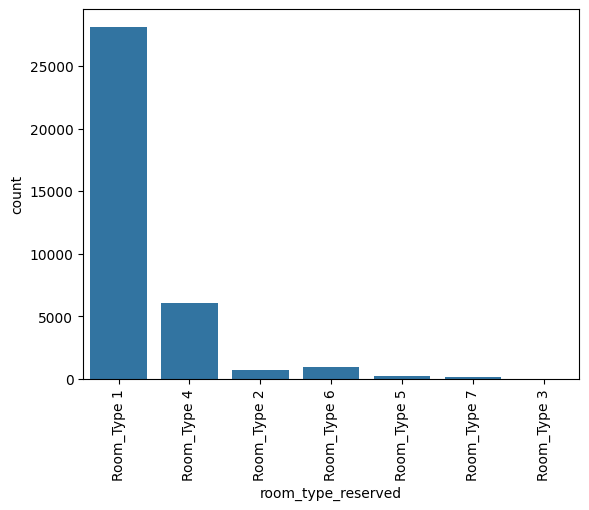

In [ ]:
sns.countplot(x='room_type_reserved', data=df)
plt.xticks(rotation=90)
plt.show()

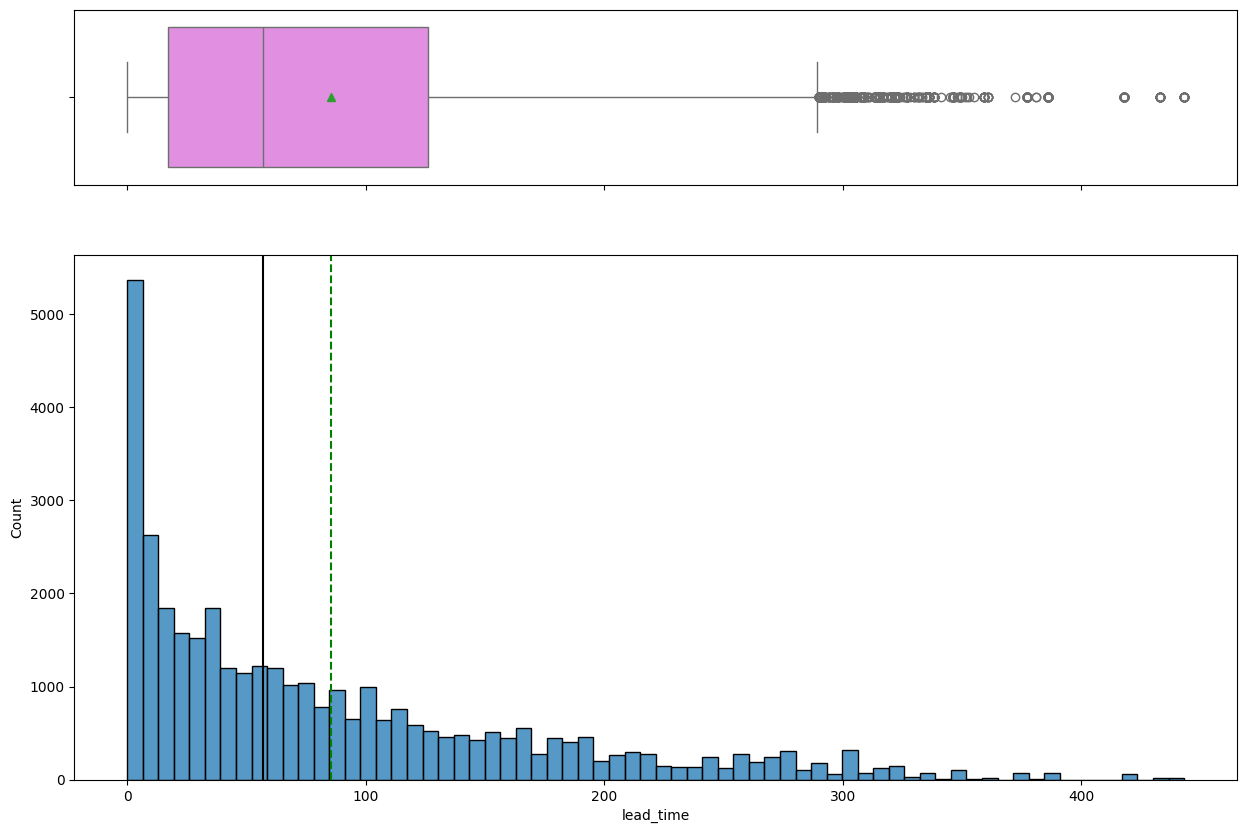

In [ ]:
histogram_boxplot(df, 'lead_time')

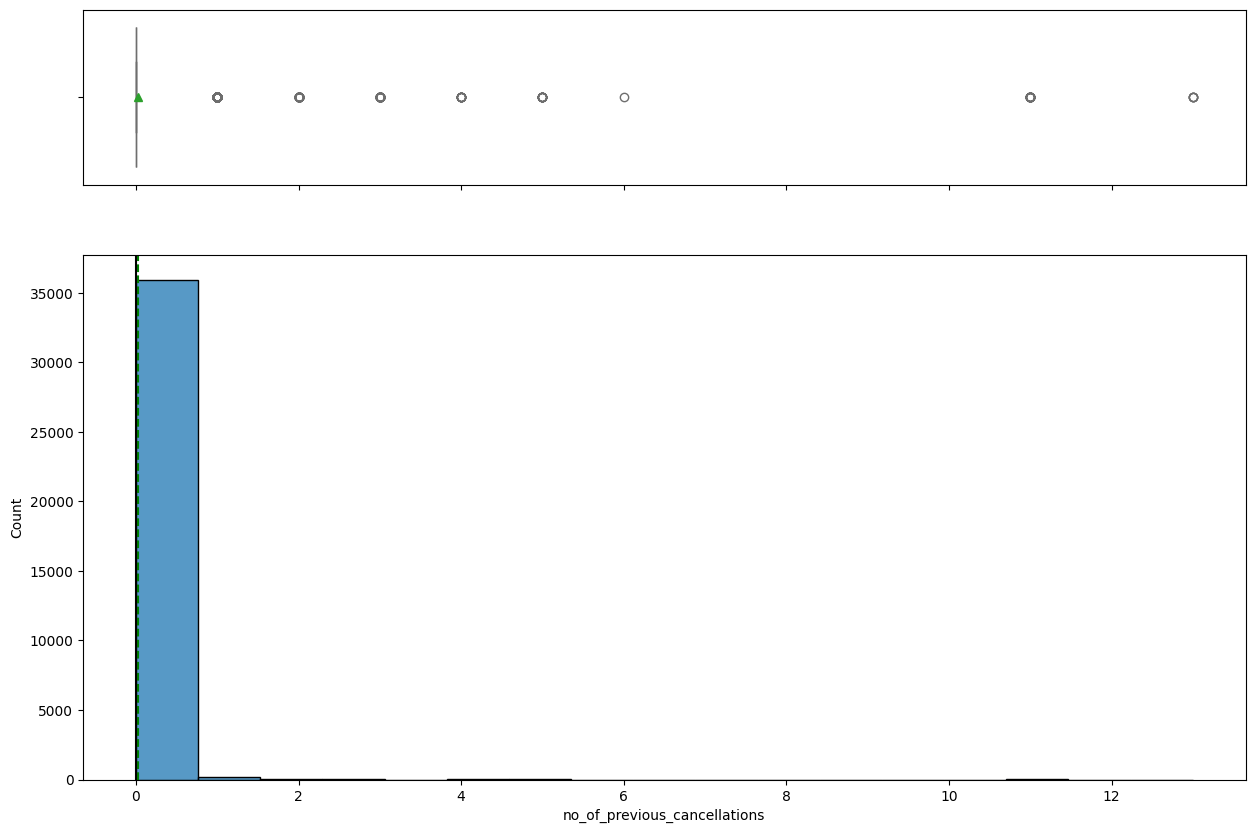

In [ ]:
histogram_boxplot(df, 'no_of_previous_cancellations')

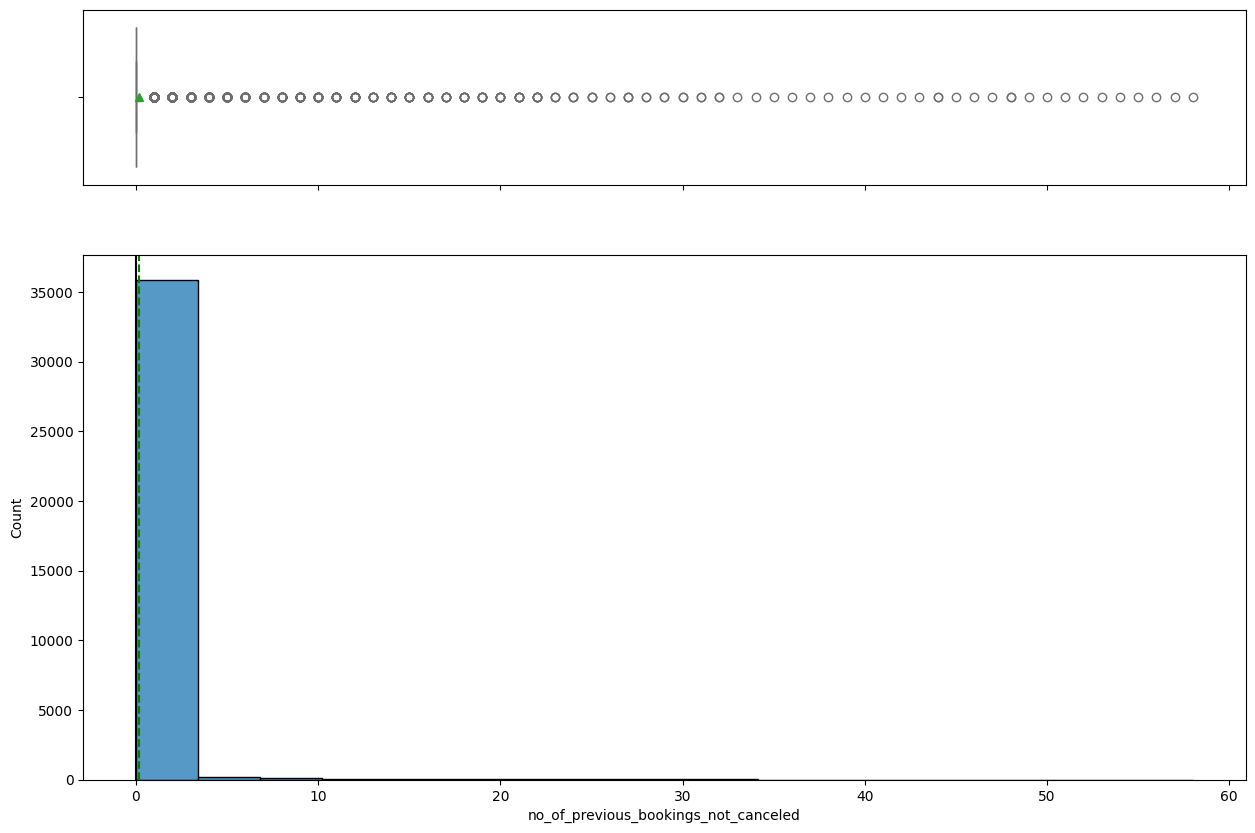

In [ ]:
histogram_boxplot(df, 'no_of_previous_bookings_not_canceled')

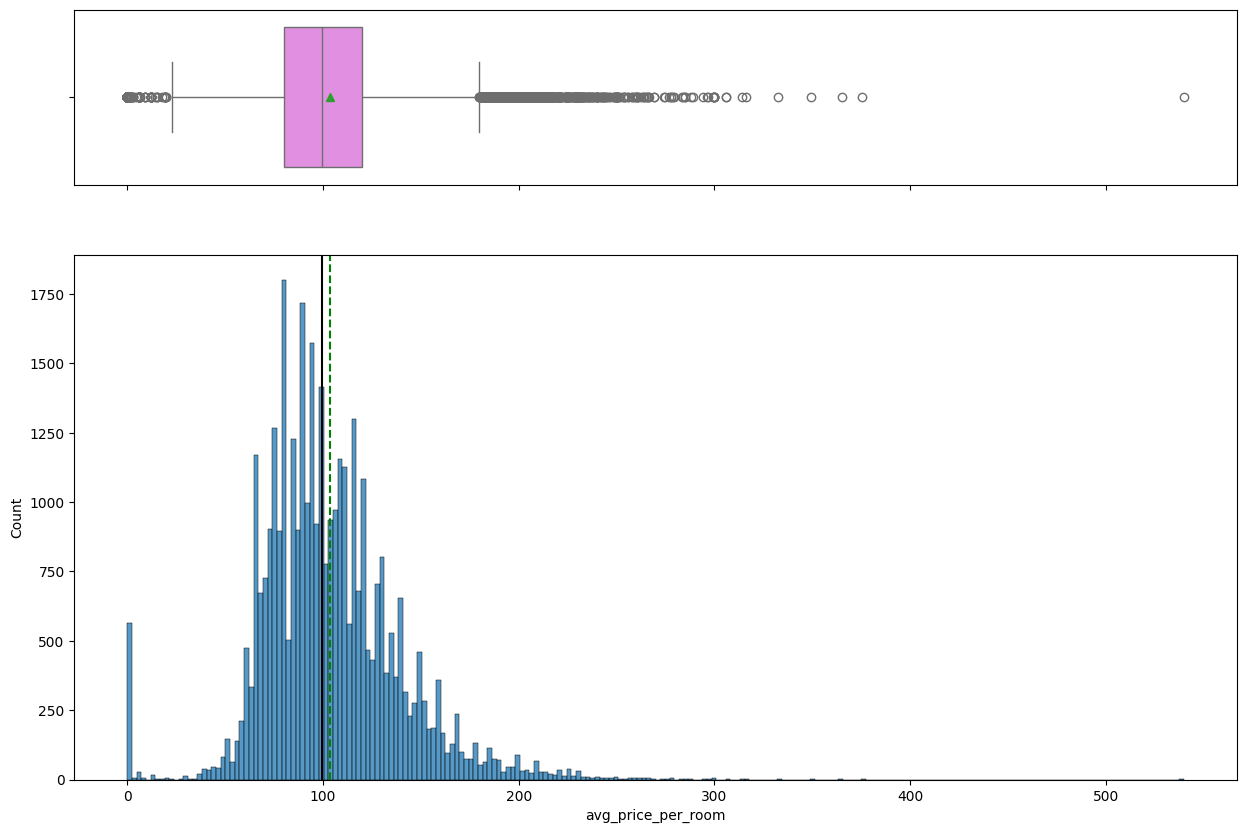

In [ ]:
histogram_boxplot(df, 'avg_price_per_room')

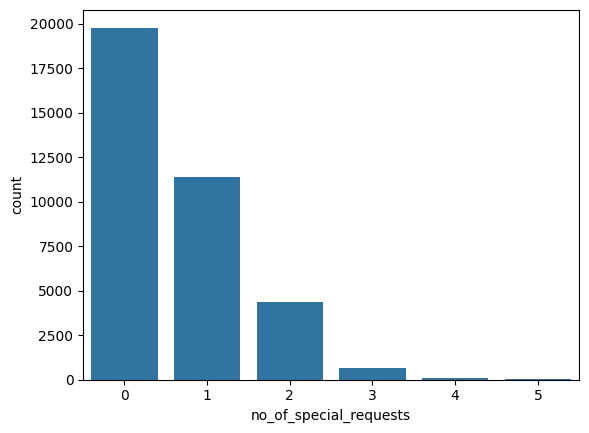

In [ ]:
sns.countplot(x='no_of_special_requests', data=df)
plt.show()

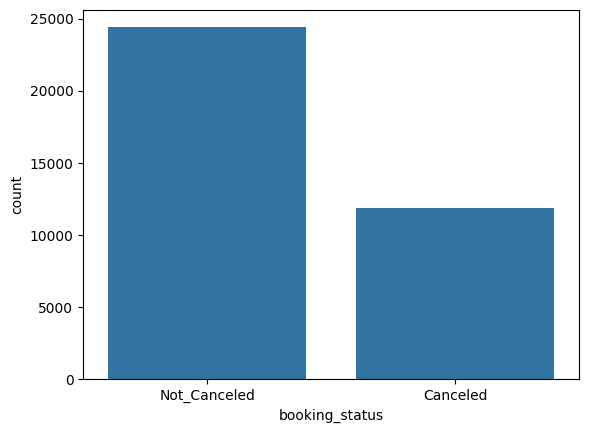

In [ ]:
sns.countplot(x='booking_status', data=df)
plt.show()

In [ ]:
df['booking_status'] = df['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

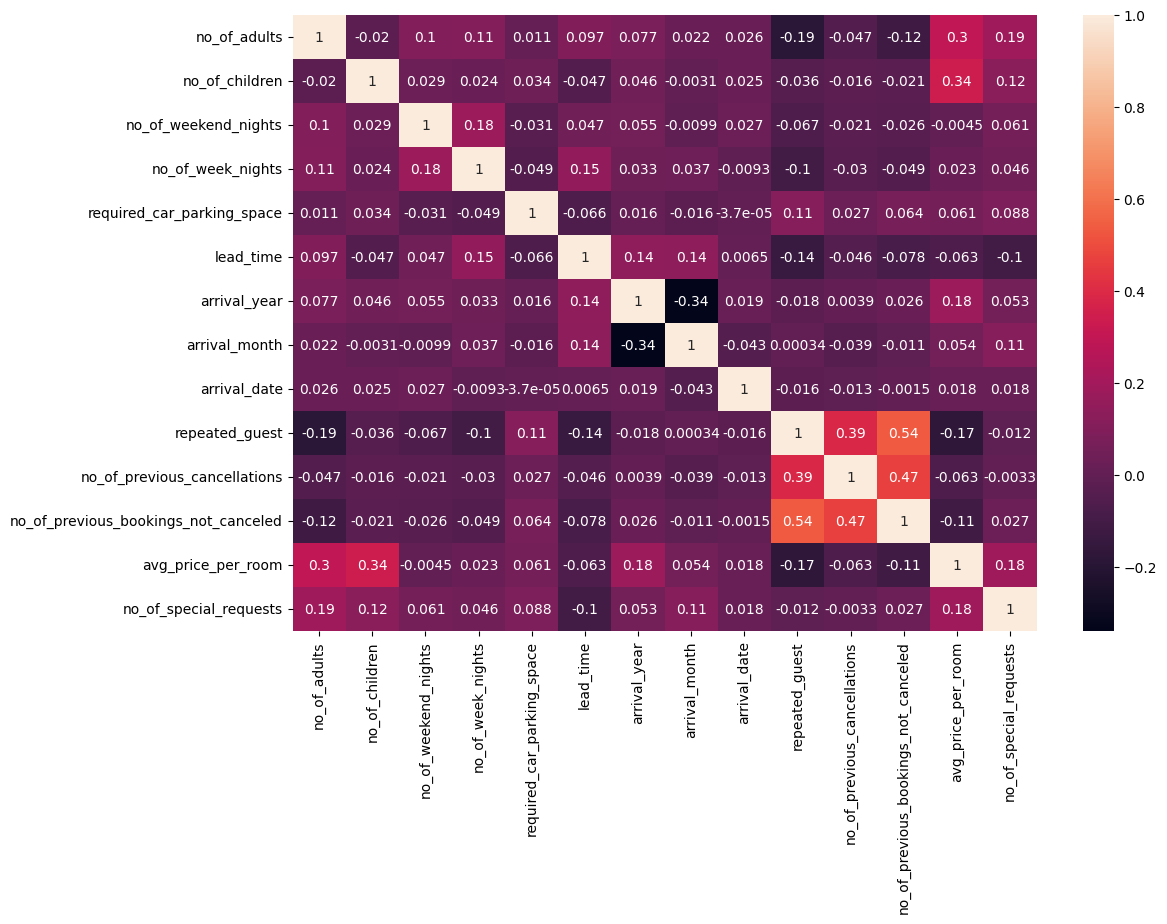

In [ ]:
cols_list = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(12, 8))
sns.heatmap(data[cols_list].corr(), annot=True)
plt.show()

* Booking status has a moderate, postive correlation with lead time.

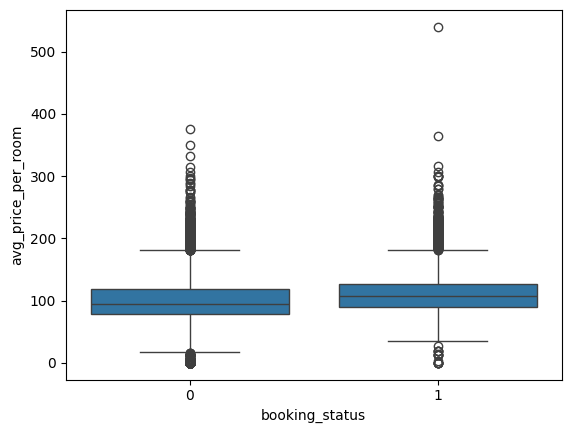

In [ ]:
sns.boxplot(x='booking_status', y='avg_price_per_room', data=df)
plt.show()

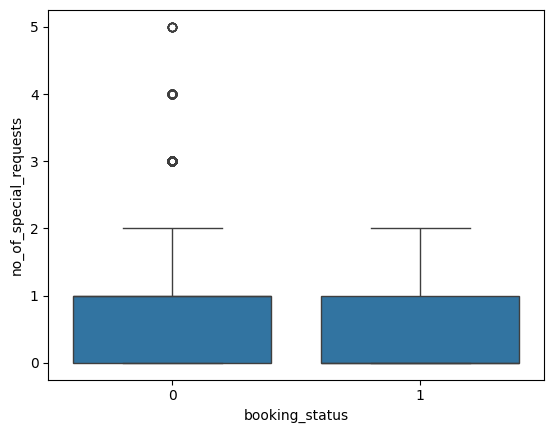

In [ ]:
sns.boxplot(x='booking_status', y='no_of_special_requests', data=df)
plt.show()

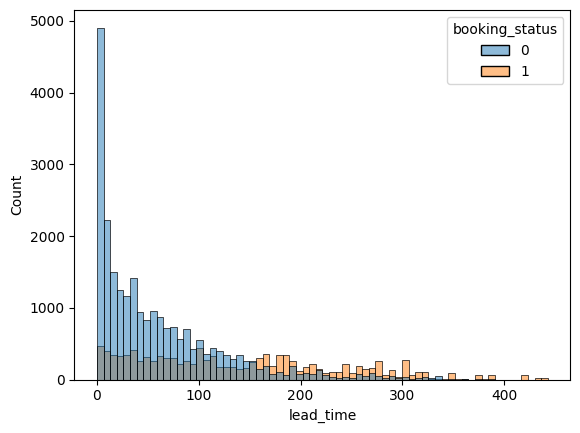

In [ ]:
sns.histplot(x='lead_time', hue='booking_status', data=df)
plt.show()

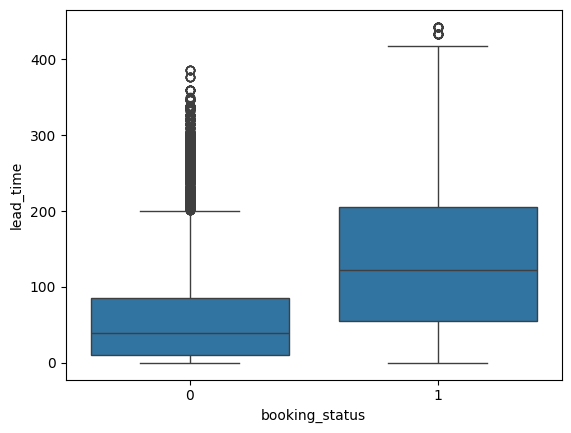

In [ ]:
sns.boxplot(x='booking_status', y='lead_time', data=df)
plt.show()

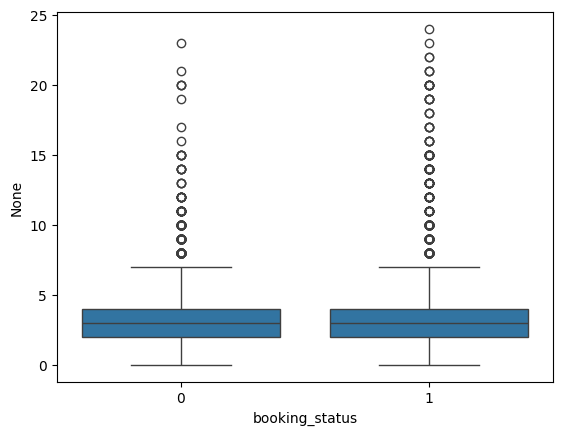

In [ ]:
sns.boxplot(x='booking_status', y=total_days, data=df)
plt.show()

In [ ]:
df_canceled = df[df['booking_status'] == 1]
monthly_canceled = df_canceled.groupby('arrival_month').size()
monthly_total = df.groupby('arrival_month').size()
percent_canceled_per_month = (monthly_canceled / monthly_total) * 100
print("Percentage of bookings canceled per month:")
print(percent_canceled_per_month)

Percentage of bookings canceled per month:
arrival_month
1     2.36686
2    25.23474
3    29.68617
4    36.36696
5    36.48961
6    40.30596
7    45.00000
8    39.02439
9    33.35502
10   35.35828
11   29.36242
12   13.30685
dtype: float64


* Bookings are canceled most frequently in July, June, and August, in that order.

In [ ]:
market_segment_canceled = df_canceled.groupby('market_segment_type').size()
market_segment_total = df.groupby('market_segment_type').size()
percent_canceled_per_market_segment = (market_segment_canceled / market_segment_total) * 100
print("Percentage of bookings canceled per market segment:")
print(percent_canceled_per_market_segment)

Percentage of bookings canceled per market segment:
market_segment_type
Aviation        29.60000
Complementary        NaN
Corporate       10.90729
Offline         29.94871
Online          36.50814
dtype: float64


* Bookings are canceled most frequently when they are booked online.

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)

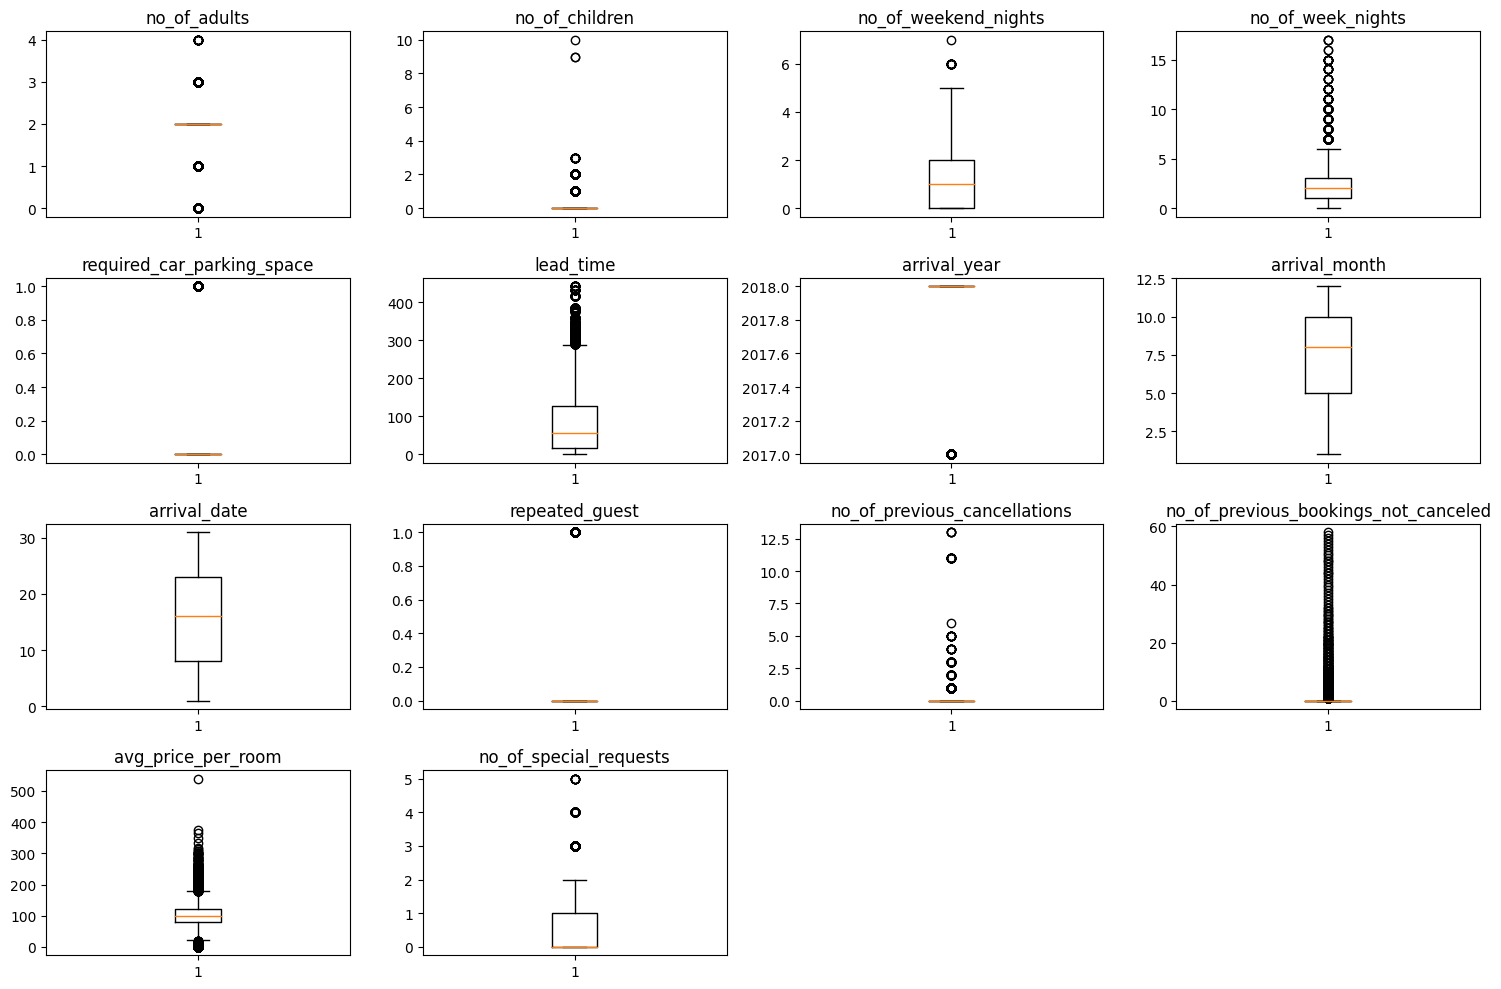

In [ ]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove('booking_status')

plt.figure(figsize=(15, 10))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [ ]:
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)

IQR = Q3 - Q1
lower_whisker = Q1 - 1.5*IQR
upper_whisker = Q3 + 1.5*IQR

((df[numeric_columns] < lower_whisker) | (df[numeric_columns] > upper_whisker)).sum()/df.shape[0]*100

no_of_adults                           28.02757
no_of_children                          7.43763
no_of_weekend_nights                    0.05789
no_of_week_nights                       0.89318
required_car_parking_space              3.09855
lead_time                               3.66919
arrival_year                           17.95727
arrival_month                           0.00000
arrival_date                            0.00000
repeated_guest                          2.56375
no_of_previous_cancellations            0.93177
no_of_previous_bookings_not_canceled    2.23846
avg_price_per_room                      4.67540
no_of_special_requests                  2.09786
dtype: float64

In [ ]:
df['no_of_children'] = df['no_of_children'].replace([9, 10], 3)

In [ ]:
df['avg_price_per_room'] = np.clip(df['avg_price_per_room'], 0, 500)

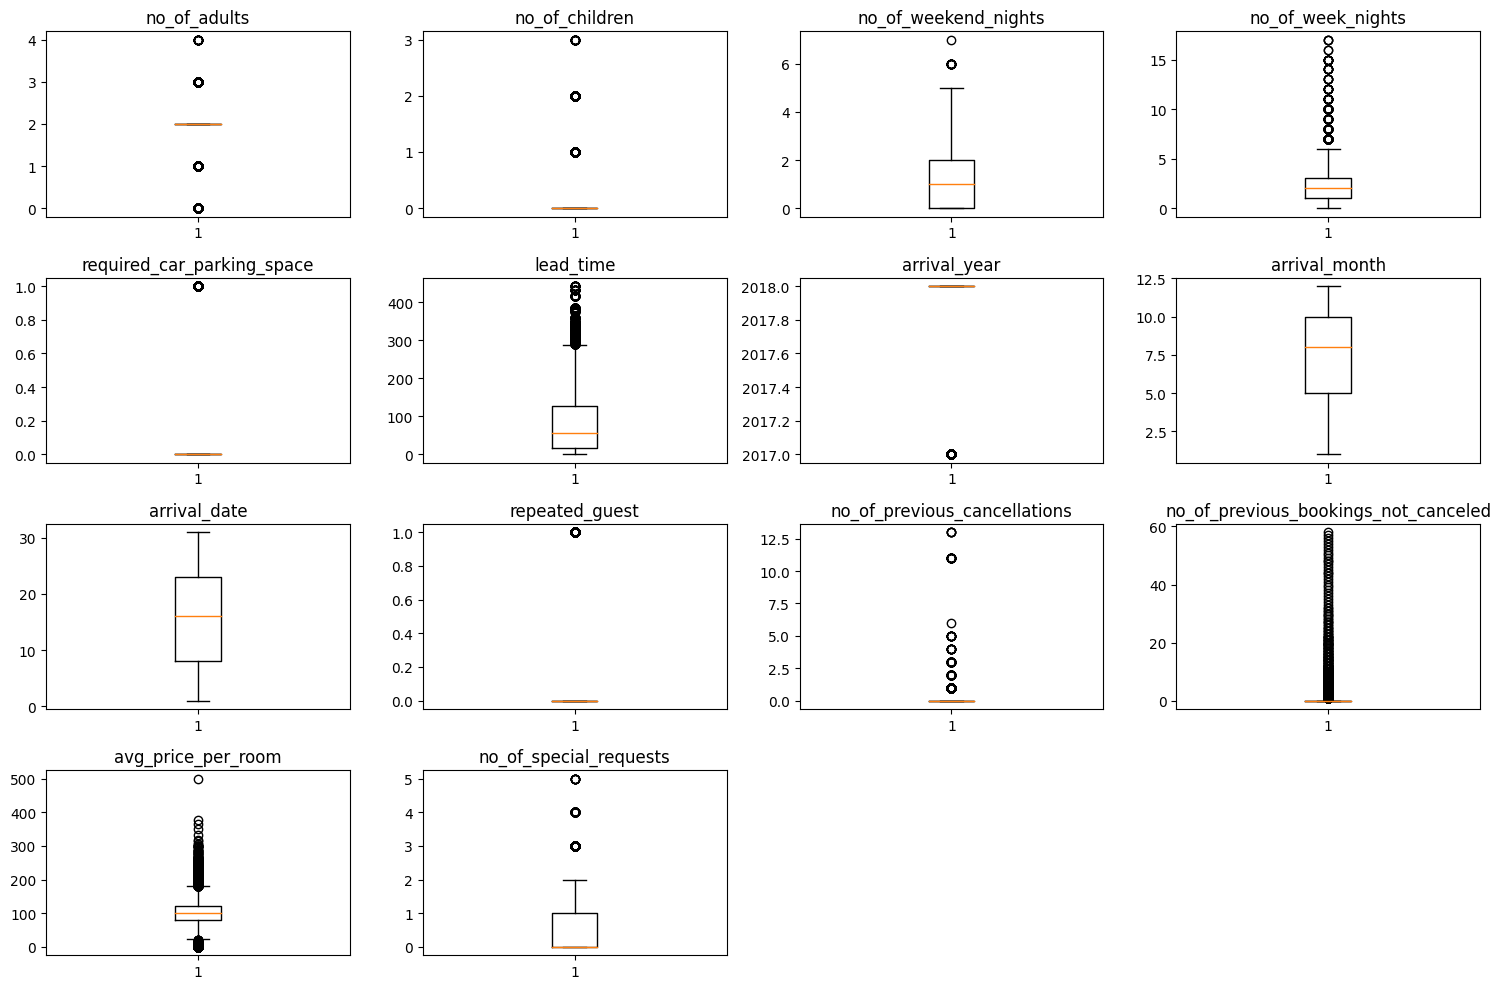

In [ ]:
plt.figure(figsize=(15, 10))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

In [ ]:
df = df.select_dtypes(exclude=['object', 'bool'])

## EDA

- It is a good idea to explore the data once again after manipulating it.

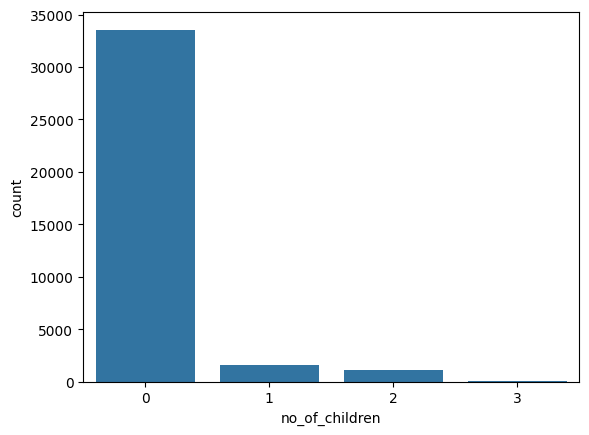

In [ ]:
sns.countplot(x='no_of_children', data=df)
plt.show()

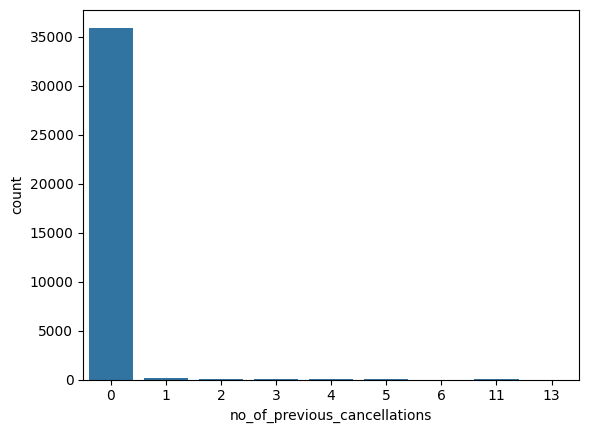

In [ ]:
sns.countplot(x='no_of_previous_cancellations', data=df)
plt.show()

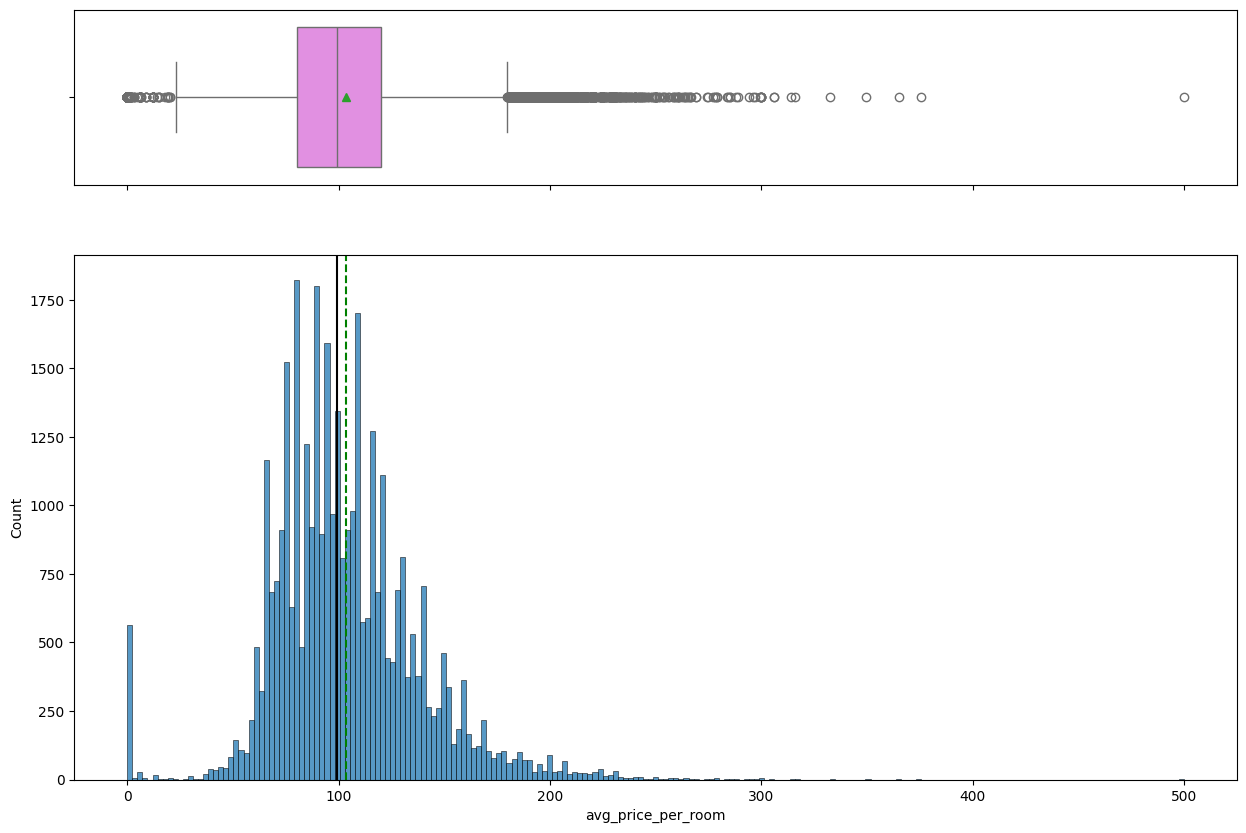

In [ ]:
histogram_boxplot(df, 'avg_price_per_room')

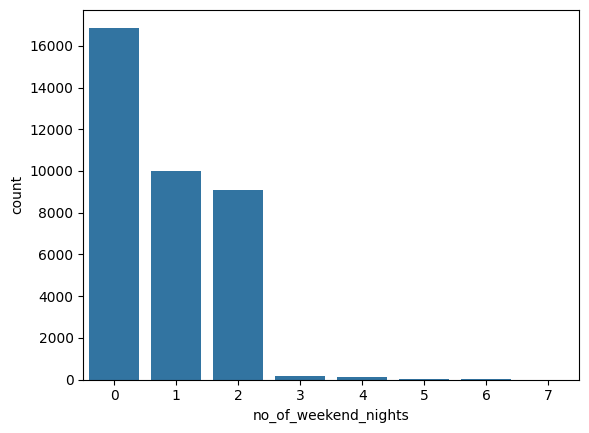

In [ ]:
sns.countplot(x='no_of_weekend_nights', data=df)
plt.show()

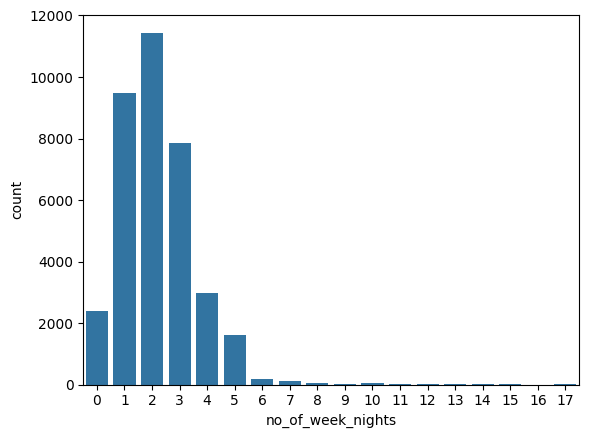

In [ ]:
sns.countplot(x='no_of_week_nights', data=df)
plt.show()

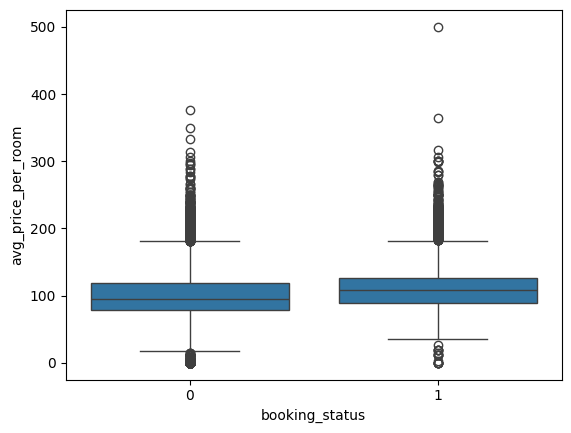

In [ ]:
sns.boxplot(x='booking_status', y='avg_price_per_room', data=df)
plt.show()

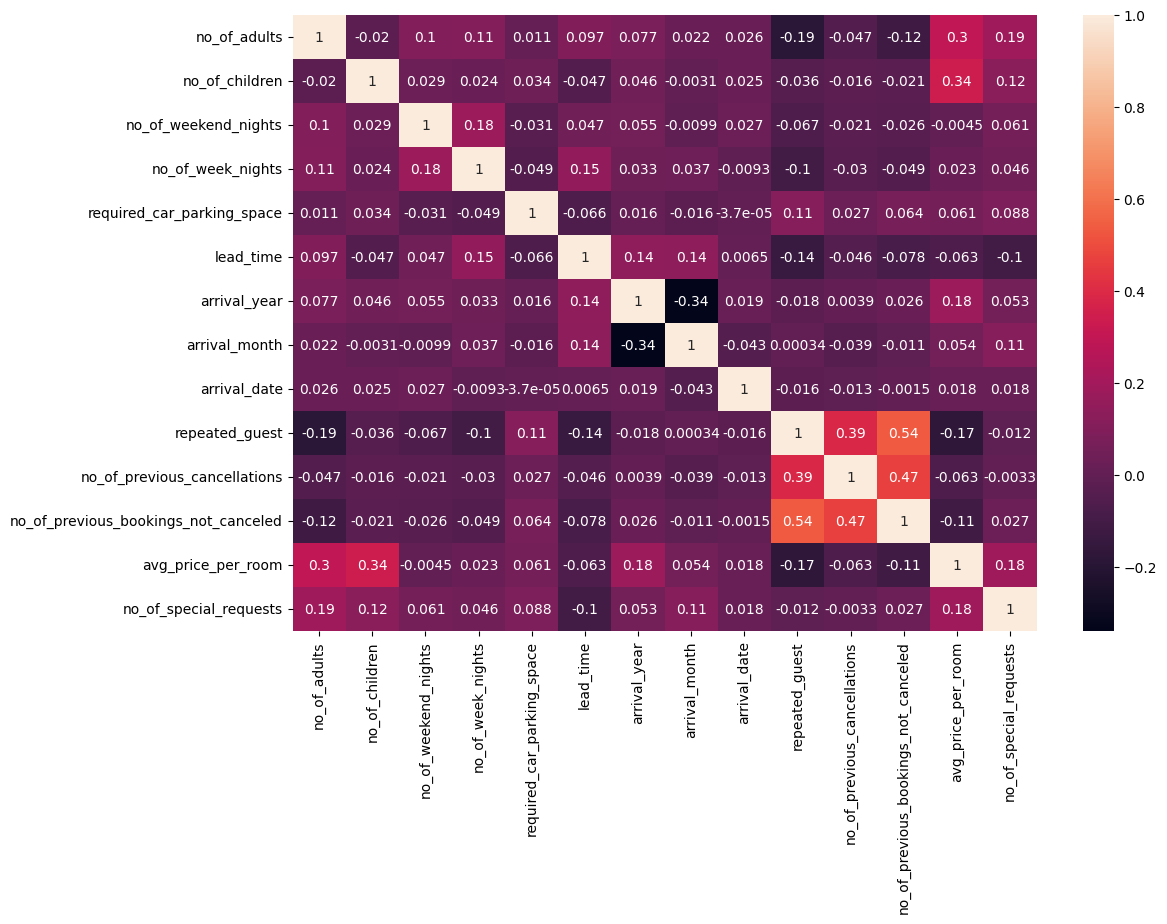

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[cols_list].corr(), annot=True)
plt.show()

## Checking Multicollinearity

- In order to make statistical inferences from a logistic regression model, it is important to ensure that there is no multicollinearity present in the data.

In [ ]:
X = df.drop(["booking_status"], axis=1)
Y = df["booking_status"]

X = sm.add_constant(X)

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=1)

In [ ]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (25392, 15)
Shape of test set :  (10883, 15)
Percentage of classes in training set:
0   0.67064
1   0.32936
Name: booking_status, dtype: float64
Percentage of classes in test set:
0   0.67638
1   0.32362
Name: booking_status, dtype: float64


In [ ]:
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [ ]:
checking_vif(X_train)

feature            VIF
0                                  const 34856941.36770
1                           no_of_adults        1.21406
2                         no_of_children        1.17468
3                   no_of_weekend_nights        1.05289
4                      no_of_week_nights        1.06932
5             required_car_parking_space        1.03412
6                              lead_time        1.15837
7                           arrival_year        1.26391
8                          arrival_month        1.24066
9                           arrival_date        1.00487
10                        repeated_guest        1.56312
11          no_of_previous_cancellations        1.37579
12  no_of_previous_bookings_not_canceled        1.63419
13                    avg_price_per_room        1.39395
14                no_of_special_requests        1.11669

## Building a Logistic Regression model

In [ ]:
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    pred_temp = model.predict(predictors) > threshold
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit(disp=False)

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25377
Method:                           MLE   Df Model:                           14
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2737
Time:                        06:51:46   Log-Likelihood:                -11688.
converged:                       True   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                -1832.5926    108.548    -16.883      0.000   -2045.342   -1619.843
no_of_adults                             0.1948      

* Guests who have required parking spaces, are repeated guests, and have special requests are less likely to cancel.

In [ ]:
print("Training performance:")
model_performance_classification_statsmodels(lg, X_train, y_train)

Training performance:


Accuracy  Recall  Precision      F1
0   0.78442 0.55482    0.72602 0.62898

In [ ]:
cols = X_train.columns.tolist()

max_p_value = 1

while len(cols) > 0:
    x_train_aux = X_train[cols]

    model = sm.Logit(y_train, x_train_aux).fit(disp=False)

    p_values = model.pvalues
    max_p_value = max(p_values)

    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'repeated_guest', 'no_of_previous_cancellations', 'avg_price_per_room', 'no_of_special_requests']


In [ ]:
X_train1 = X_train[selected_features]

X_test1 = X_test[selected_features]

In [ ]:
logit1 = sm.Logit(y_train, X_train1.astype(float))
lg1 = logit1.fit(disp=False)
print(lg1.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25380
Method:                           MLE   Df Model:                           11
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2735
Time:                        06:51:48   Log-Likelihood:                -11690.
converged:                       True   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -1829.0054    108.604    -16.841      0.000   -2041.865   -1616.145
no_of_adults                     0.1905      0.034      5.682      0.000     

In [ ]:
odds = np.exp(lg1.params)

perc_change_odds = (np.exp(lg1.params) - 1) * 100

pd.set_option("display.max_columns", None)

pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train1.columns).T

const  no_of_adults  no_of_weekend_nights  no_of_week_nights  \
Odds           0.00000       1.20986               1.15369            1.05482   
Change_odd% -100.00000      20.98609              15.36909            5.48241   

             required_car_parking_space  lead_time  arrival_year  \
Odds                            0.27020    1.01244       2.47107   
Change_odd%                   -72.98008    1.24401     147.10660   

             arrival_month  repeated_guest  no_of_previous_cancellations  \
Odds               0.97245         0.07007                       1.23377   
Change_odd%       -2.75481       -92.99327                      23.37679   

             avg_price_per_room  no_of_special_requests  
Odds                    1.01821                 0.33138  
Change_odd%             1.82145               -66.86210

**Observation**
*   `required_car_parking_space`: Holding all other features constant a 1 unit change in Required Car Parking Spaces will decrease the odds of a guest cancelling by ~0.27 times or a ~21% decrease in odds cancelling.
*   `repeated_guest`: Holding all other features constant a 1 unit change in Repeated Guest will decrease the odds of a guest cancelling by ~0.07 times or a ~93% decrease in odds cancelling.
*   `no_of_special_requests`: Holding all other features constant a 1 unit change in Number of Special Requests will decrease the odds of a guest cancelling by ~0.33 times or a ~67% decrease in odds cancelling.
*   `no_of_adults`: Holding all other features constant a 1 unit change in Number of Adults will increase the odds of a guest cancelling by ~1.21 times or a ~21% increase in odds cancelling.
*   `no_of_previous_cancellations`: Holding all other features constant a 1 unit change in Number of Previous Cancellations will increase the odds of a guest cancelling by ~1.23 times or a ~23% increase in odds cancelling.

## Model performance evaluation

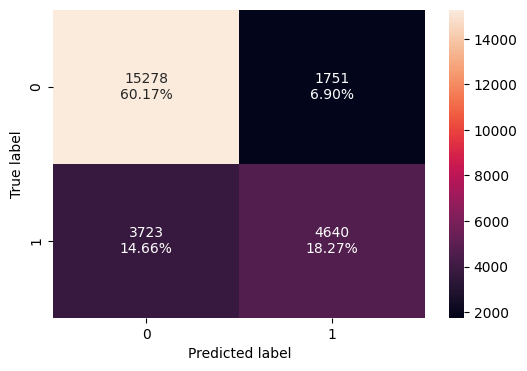

In [ ]:
confusion_matrix_statsmodels(lg, X_train, y_train)

In [ ]:
print("Training performance:")
log_reg_model_train_perf = model_performance_classification_statsmodels(lg, X_train, y_train)
log_reg_model_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.78442 0.55482    0.72602 0.62898

In [ ]:
X_test1 = X_test[list(X_train1.columns)]

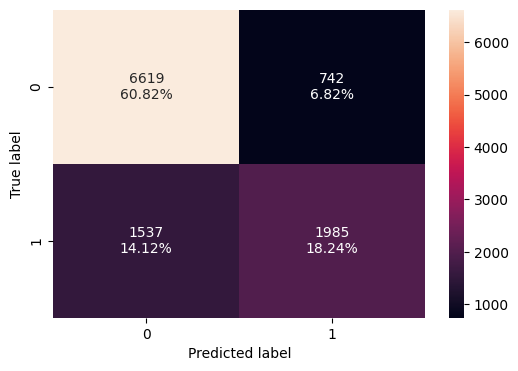

In [ ]:
confusion_matrix_statsmodels(lg1, X_test1, y_test)

In [ ]:
log_reg_model_test_perf = model_performance_classification_statsmodels(
    lg1, X_test1, y_test
)

print("Test performance:")
log_reg_model_test_perf

Test performance:


Accuracy  Recall  Precision      F1
0   0.79059 0.56360    0.72791 0.63530

*   The model is giving a F1 sccore of ~0.62898 and ~0.63530 on the train and test sets respectively.
*   The train and test performances are comparable, therefore, the model is not overfitting.



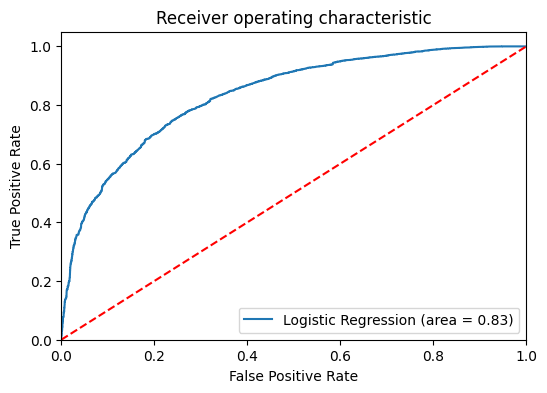

In [ ]:
logit_roc_auc_train = roc_auc_score(y_train, lg1.predict(X_train1))
fpr, tpr, thresholds = roc_curve(y_train, lg1.predict(X_train1))
plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, lg1.predict(X_train1))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.3307658997179622


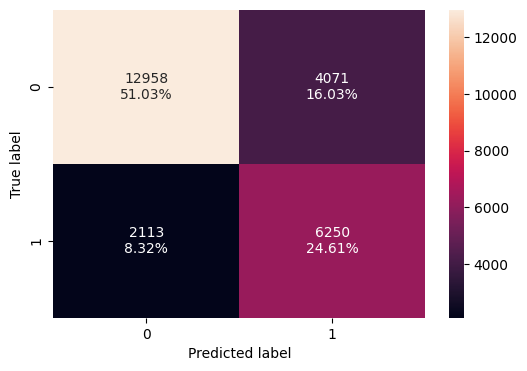

In [ ]:
confusion_matrix_statsmodels(lg1, X_train1, y_train, optimal_threshold)

In [ ]:
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_statsmodels(lg1, X_train1, y_train, optimal_threshold)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


Accuracy  Recall  Precision      F1
0   0.75646 0.74734    0.60556 0.66902

*   Recall and F1 have increased while Accuracy and Precision has decreased.



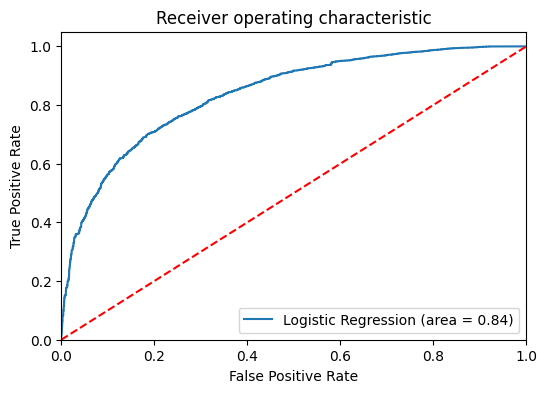

In [ ]:
logit_roc_auc_train = roc_auc_score(y_test, lg1.predict(X_test1))
fpr, tpr, thresholds = roc_curve(y_test, lg1.predict(X_test1))
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

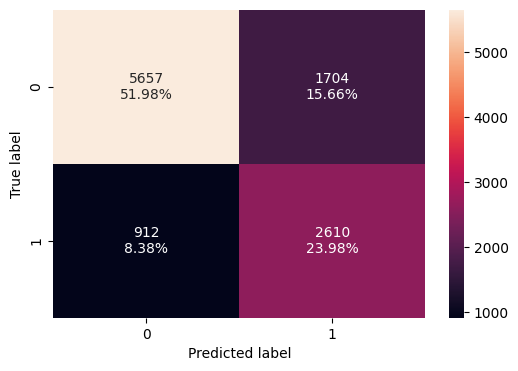

In [ ]:
confusion_matrix_statsmodels(lg1, X_test1, y_test, optimal_threshold)

In [ ]:
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_statsmodels(lg1, X_test1, y_test, optimal_threshold)
print("Test performance:")
log_reg_model_test_perf_threshold_auc_roc

Test performance:


Accuracy  Recall  Precision      F1
0   0.75963 0.74106    0.60501 0.66616

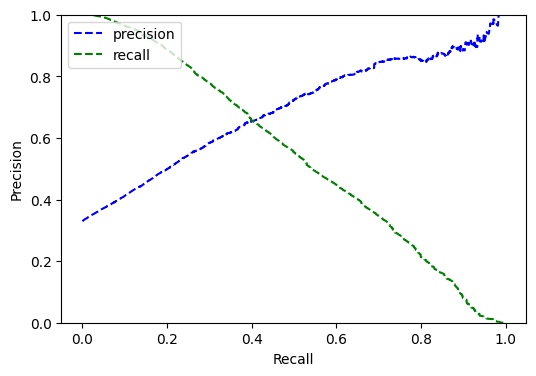

In [ ]:
y_scores = lg1.predict(X_train1)
prec, rec, tre = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plt.figure(figsize=(6, 4))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
optimal_threshold_curve = 0.42

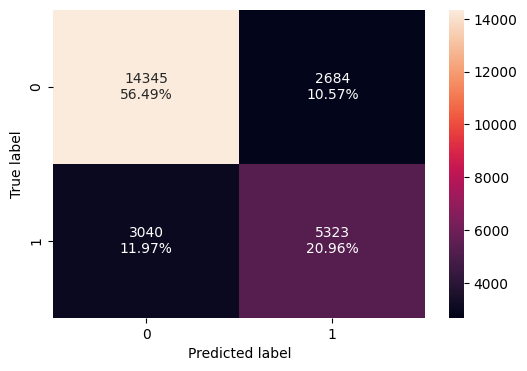

In [ ]:
confusion_matrix_statsmodels(lg1, X_train1, y_train, optimal_threshold_curve)

In [ ]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_statsmodels(lg1, X_train1, y_train, optimal_threshold_curve)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


Accuracy  Recall  Precision      F1
0   0.77457 0.63649    0.66479 0.65034

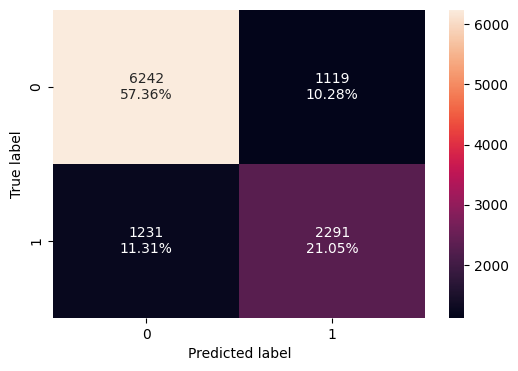

In [ ]:
confusion_matrix_statsmodels(lg1, X_test1, y_test, optimal_threshold_curve)

In [ ]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_statsmodels(lg1, X_test1, y_test, optimal_threshold_curve)
print("Test performance:")
log_reg_model_test_perf_threshold_curve

Test performance:


Accuracy  Recall  Precision      F1
0   0.78407 0.65048    0.67185 0.66099

## Final Model Summary

In [ ]:
models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression-default Threshold (0.5)",
    "Logistic Regression-0.76 Threshold",
    "Logistic Regression-0.58 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Logistic Regression-default Threshold (0.5)  \
Accuracy                                       0.78442   
Recall                                         0.55482   
Precision                                      0.72602   
F1                                             0.62898   

           Logistic Regression-0.76 Threshold  \
Accuracy                              0.75646   
Recall                                0.74734   
Precision                             0.60556   
F1                                    0.66902   

           Logistic Regression-0.58 Threshold  
Accuracy                              0.77457  
Recall                                0.63649  
Precision                             0.66479  
F1                                    0.65034

In [ ]:
models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression-default Threshold (0.5)",
    "Logistic Regression-0.76 Threshold",
    "Logistic Regression-0.58 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


Logistic Regression-default Threshold (0.5)  \
Accuracy                                       0.79059   
Recall                                         0.56360   
Precision                                      0.72791   
F1                                             0.63530   

           Logistic Regression-0.76 Threshold  \
Accuracy                              0.75963   
Recall                                0.74106   
Precision                             0.60501   
F1                                    0.66616   

           Logistic Regression-0.58 Threshold  
Accuracy                              0.78407  
Recall                                0.65048  
Precision                             0.67185  
F1                                    0.66099

In [ ]:
models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression-default Threshold (0.5)",
    "Logistic Regression-0.76 Threshold",
    "Logistic Regression-0.58 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


Logistic Regression-default Threshold (0.5)  \
Accuracy                                       0.79059   
Recall                                         0.56360   
Precision                                      0.72791   
F1                                             0.63530   

           Logistic Regression-0.76 Threshold  \
Accuracy                              0.75963   
Recall                                0.74106   
Precision                             0.60501   
F1                                    0.66616   

           Logistic Regression-0.58 Threshold  
Accuracy                              0.78407  
Recall                                0.65048  
Precision                             0.67185  
F1                                    0.66099

## Building a Decision Tree model

In [ ]:
X = df.drop(["booking_status"], axis=1)
Y = df["booking_status"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=1)

In [ ]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (25392, 14)
Shape of test set :  (10883, 14)
Percentage of classes in training set:
0   0.67064
1   0.32936
Name: booking_status, dtype: float64
Percentage of classes in test set:
0   0.67638
1   0.32362
Name: booking_status, dtype: float64


In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
print("Accuracy on training set : ",dTree.score(X_train, y_train))
print("Accuracy on test set : ",dTree.score(X_test, y_test))

Accuracy on training set :  0.9935412728418399
Accuracy on test set :  0.8578516953046035


In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
decision_tree_perf_train = model_performance_classification_sklearn(model, X_train, y_train)
print("Training performance:")
decision_tree_perf_train

Training performance:


Accuracy  Recall  Precision      F1
0   0.99354 0.98529    0.99505 0.99015

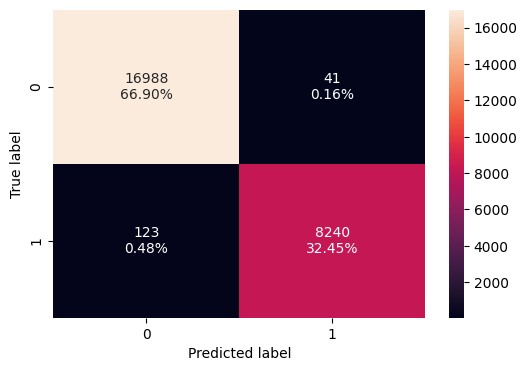

In [ ]:
confusion_matrix_sklearn(model, X_train, y_train)

In [ ]:
decision_tree_perf_test = model_performance_classification_sklearn(model, X_test, y_test)
print("Test performance:")
decision_tree_perf_test

Test performance:


Accuracy  Recall  Precision      F1
0   0.85785 0.78393    0.77840 0.78116

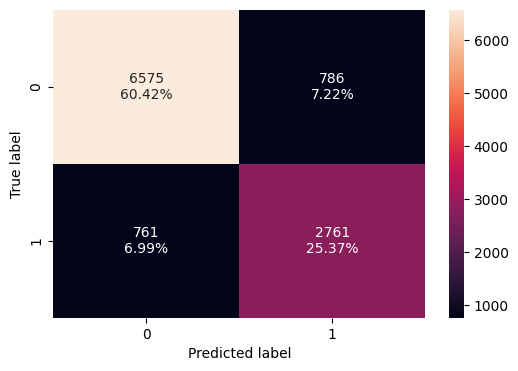

In [ ]:
confusion_matrix_sklearn(model, X_test, y_test)

In [ ]:
feature_names = list(X.columns)
print(feature_names)

['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


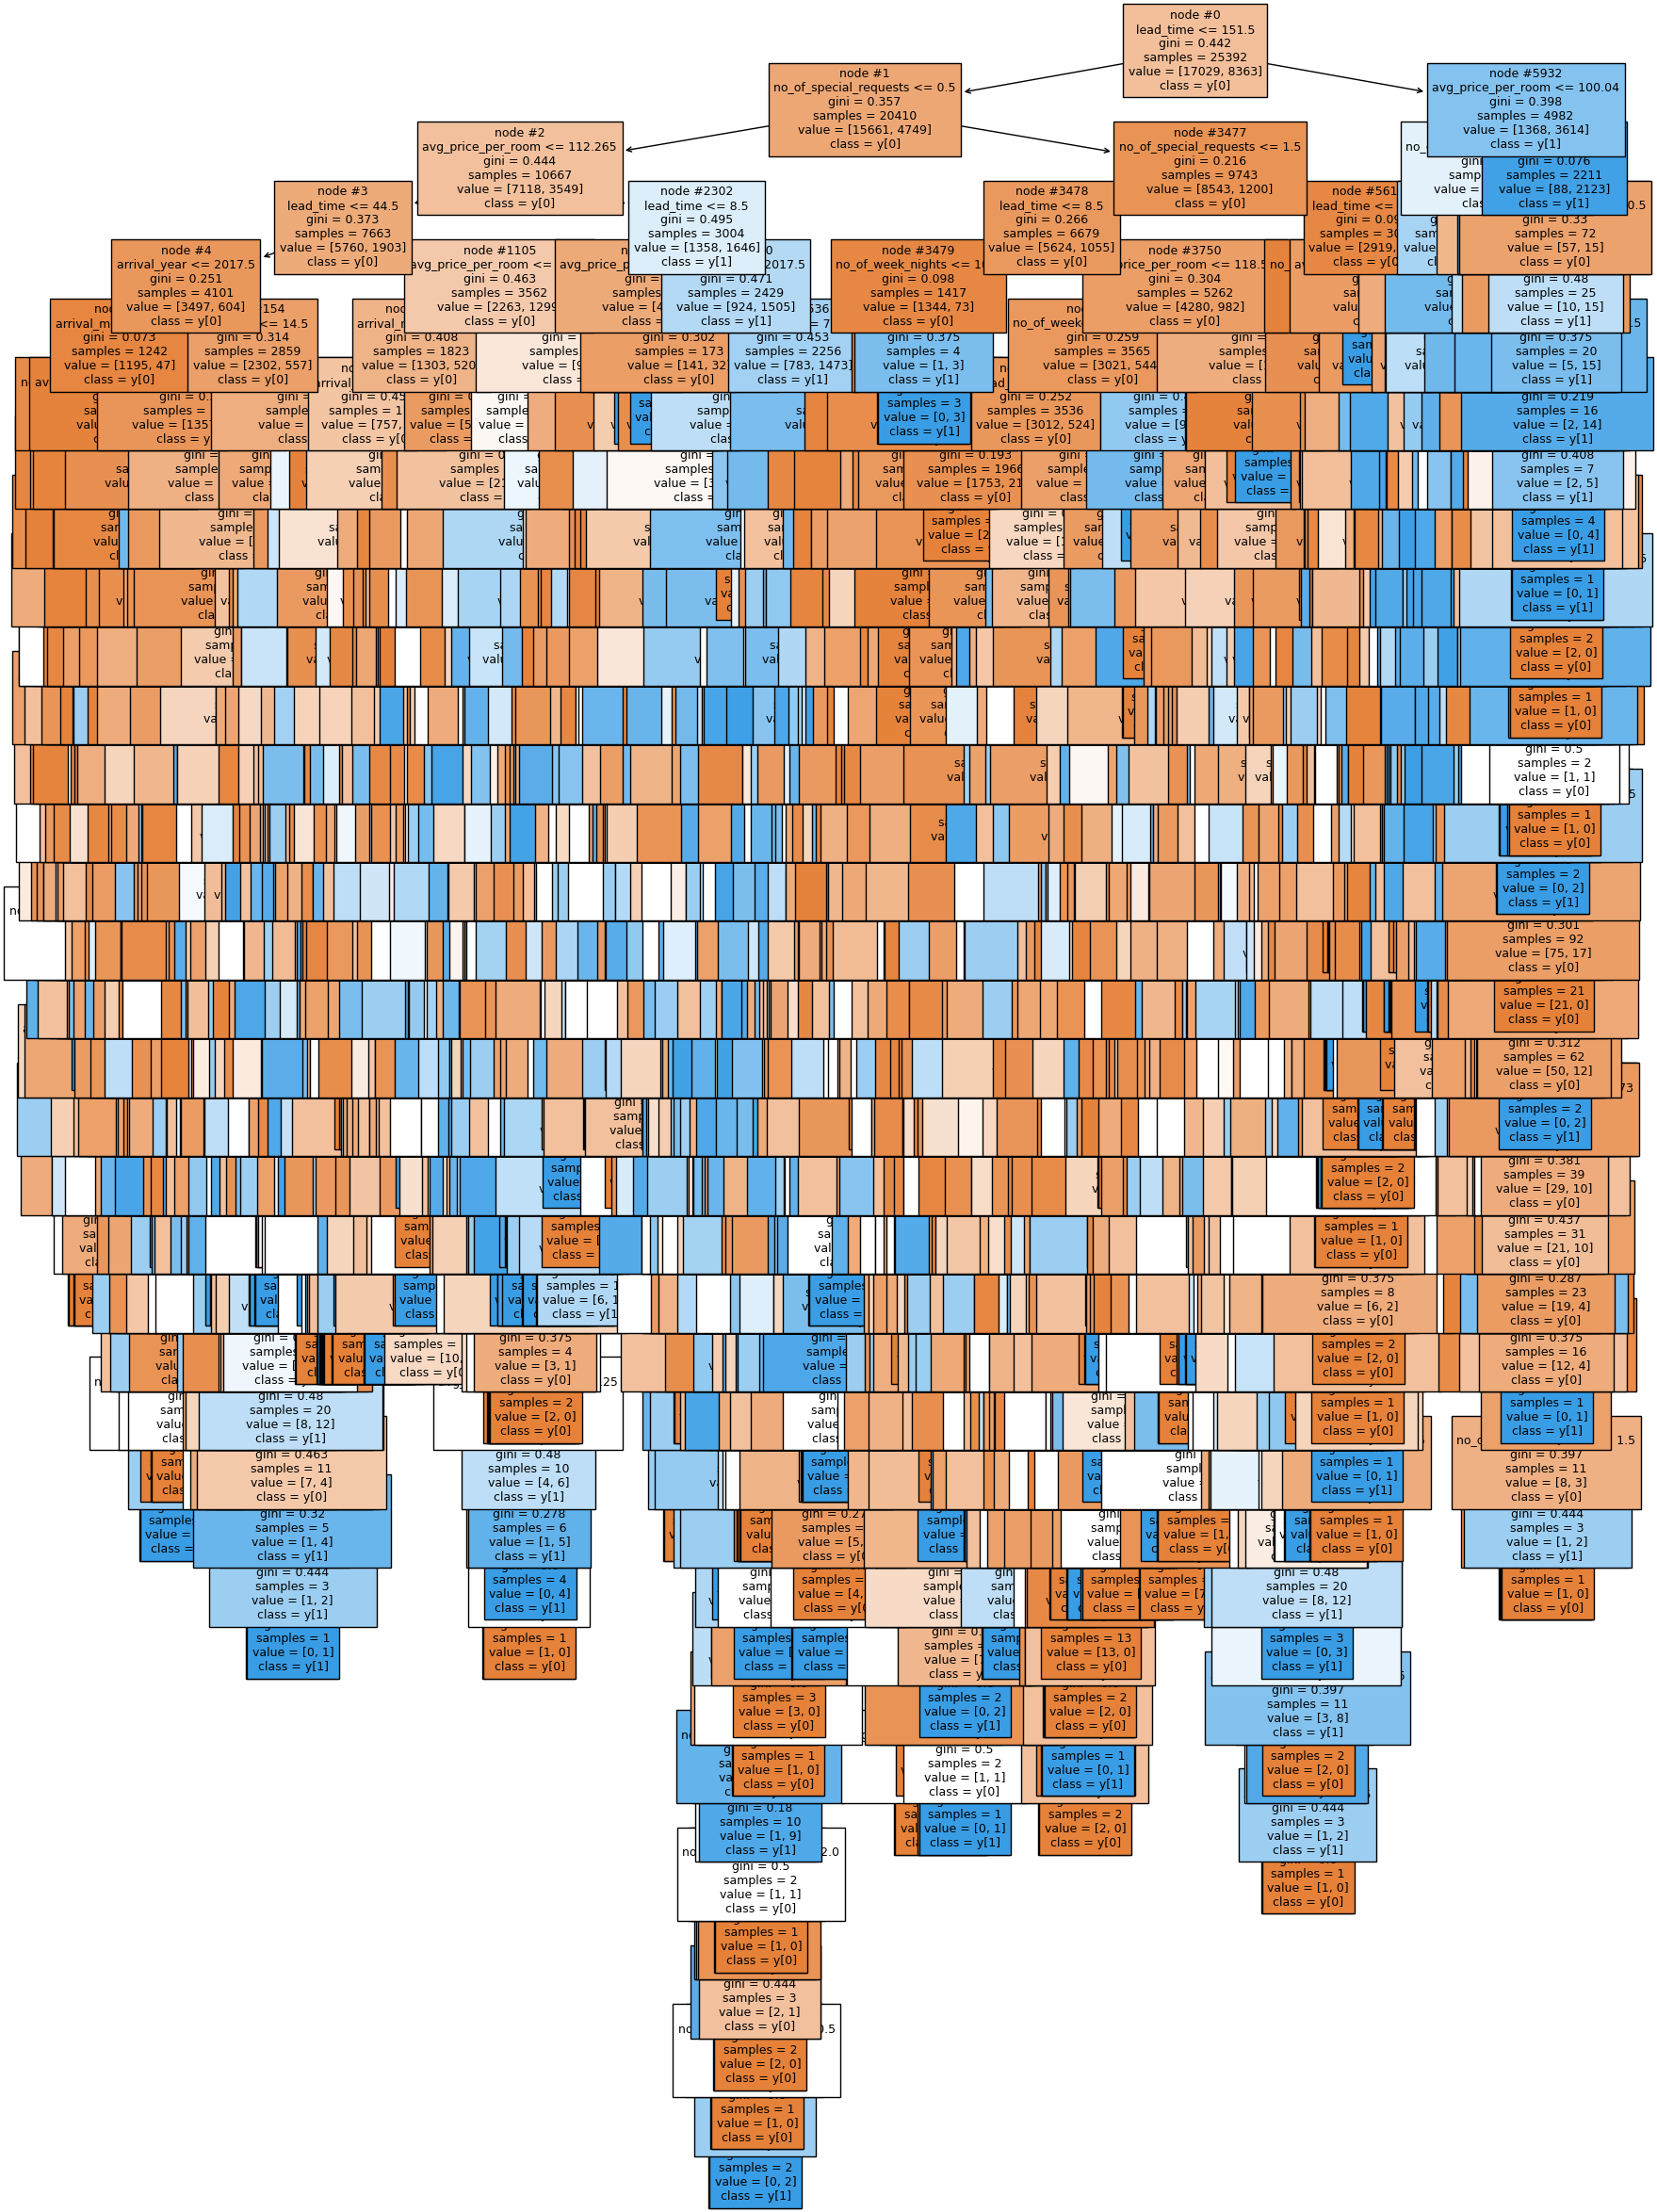

In [ ]:
plt.figure(figsize=(20,30))
tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

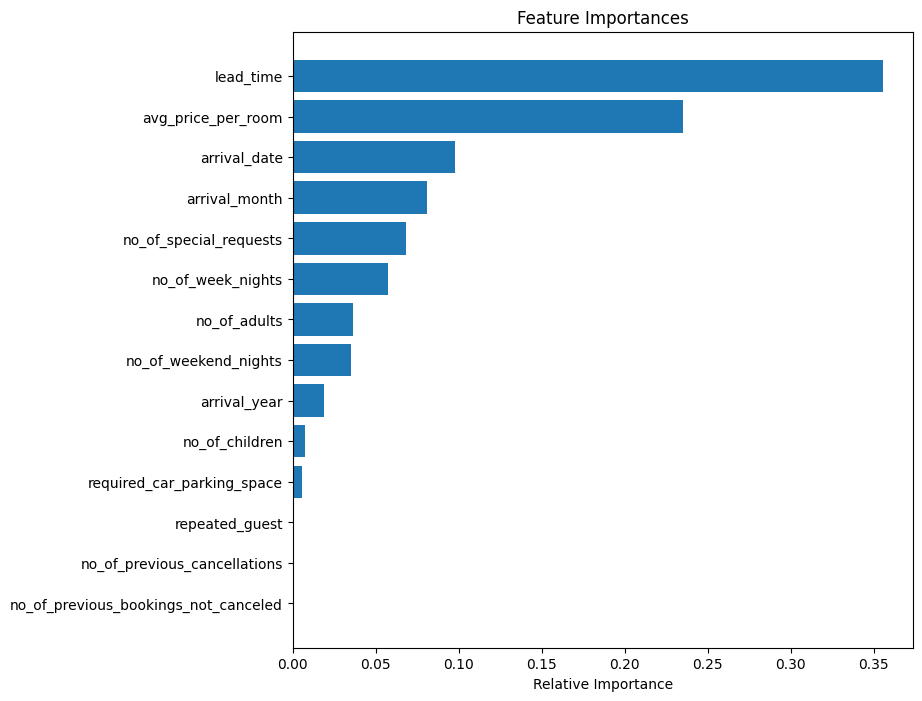

In [ ]:
feature_names = list(X_train.columns)
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

*   Lead Time appears to be the most important variable for predicting if a guest cancels.

## Do we need to prune the tree?

In [ ]:
estimator = DecisionTreeClassifier(random_state=1, class_weight='balanced')

parameters = {"max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
             }

acc_scorer = make_scorer(f1_score)

grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

estimator = grid_obj.best_estimator_

estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=50,
                       min_samples_split=30, random_state=1)

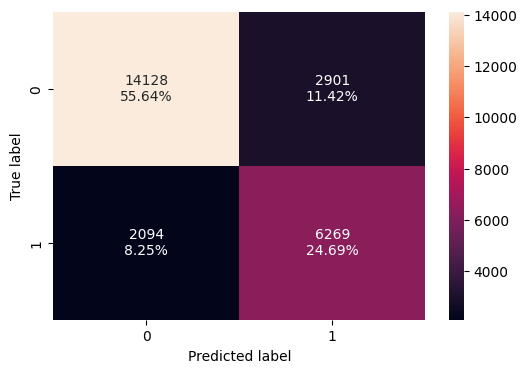

In [ ]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [ ]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(estimator, X_train, y_train)
print("Training performance:")
decision_tree_tune_perf_train

Training performance:


Accuracy  Recall  Precision      F1
0   0.80328 0.74961    0.68364 0.71511

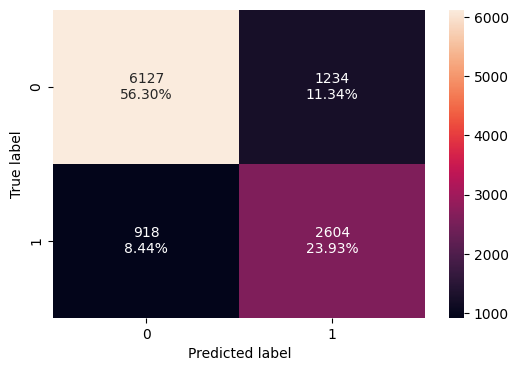

In [ ]:
confusion_matrix_sklearn(estimator, X_test, y_test)

In [ ]:
decision_tree_perf_test = model_performance_classification_sklearn(estimator, X_test, y_test)
print("Test performance:")
decision_tree_perf_test

Test performance:


Accuracy  Recall  Precision      F1
0   0.80226 0.73935    0.67848 0.70761

In [ ]:
print("Accuracy on training set: ", estimator.score(X_train, y_train))
print("Accuracy on test set: ", estimator.score(X_test, y_test))

Accuracy on training set:  0.8032844990548205
Accuracy on test set:  0.8022604061380134


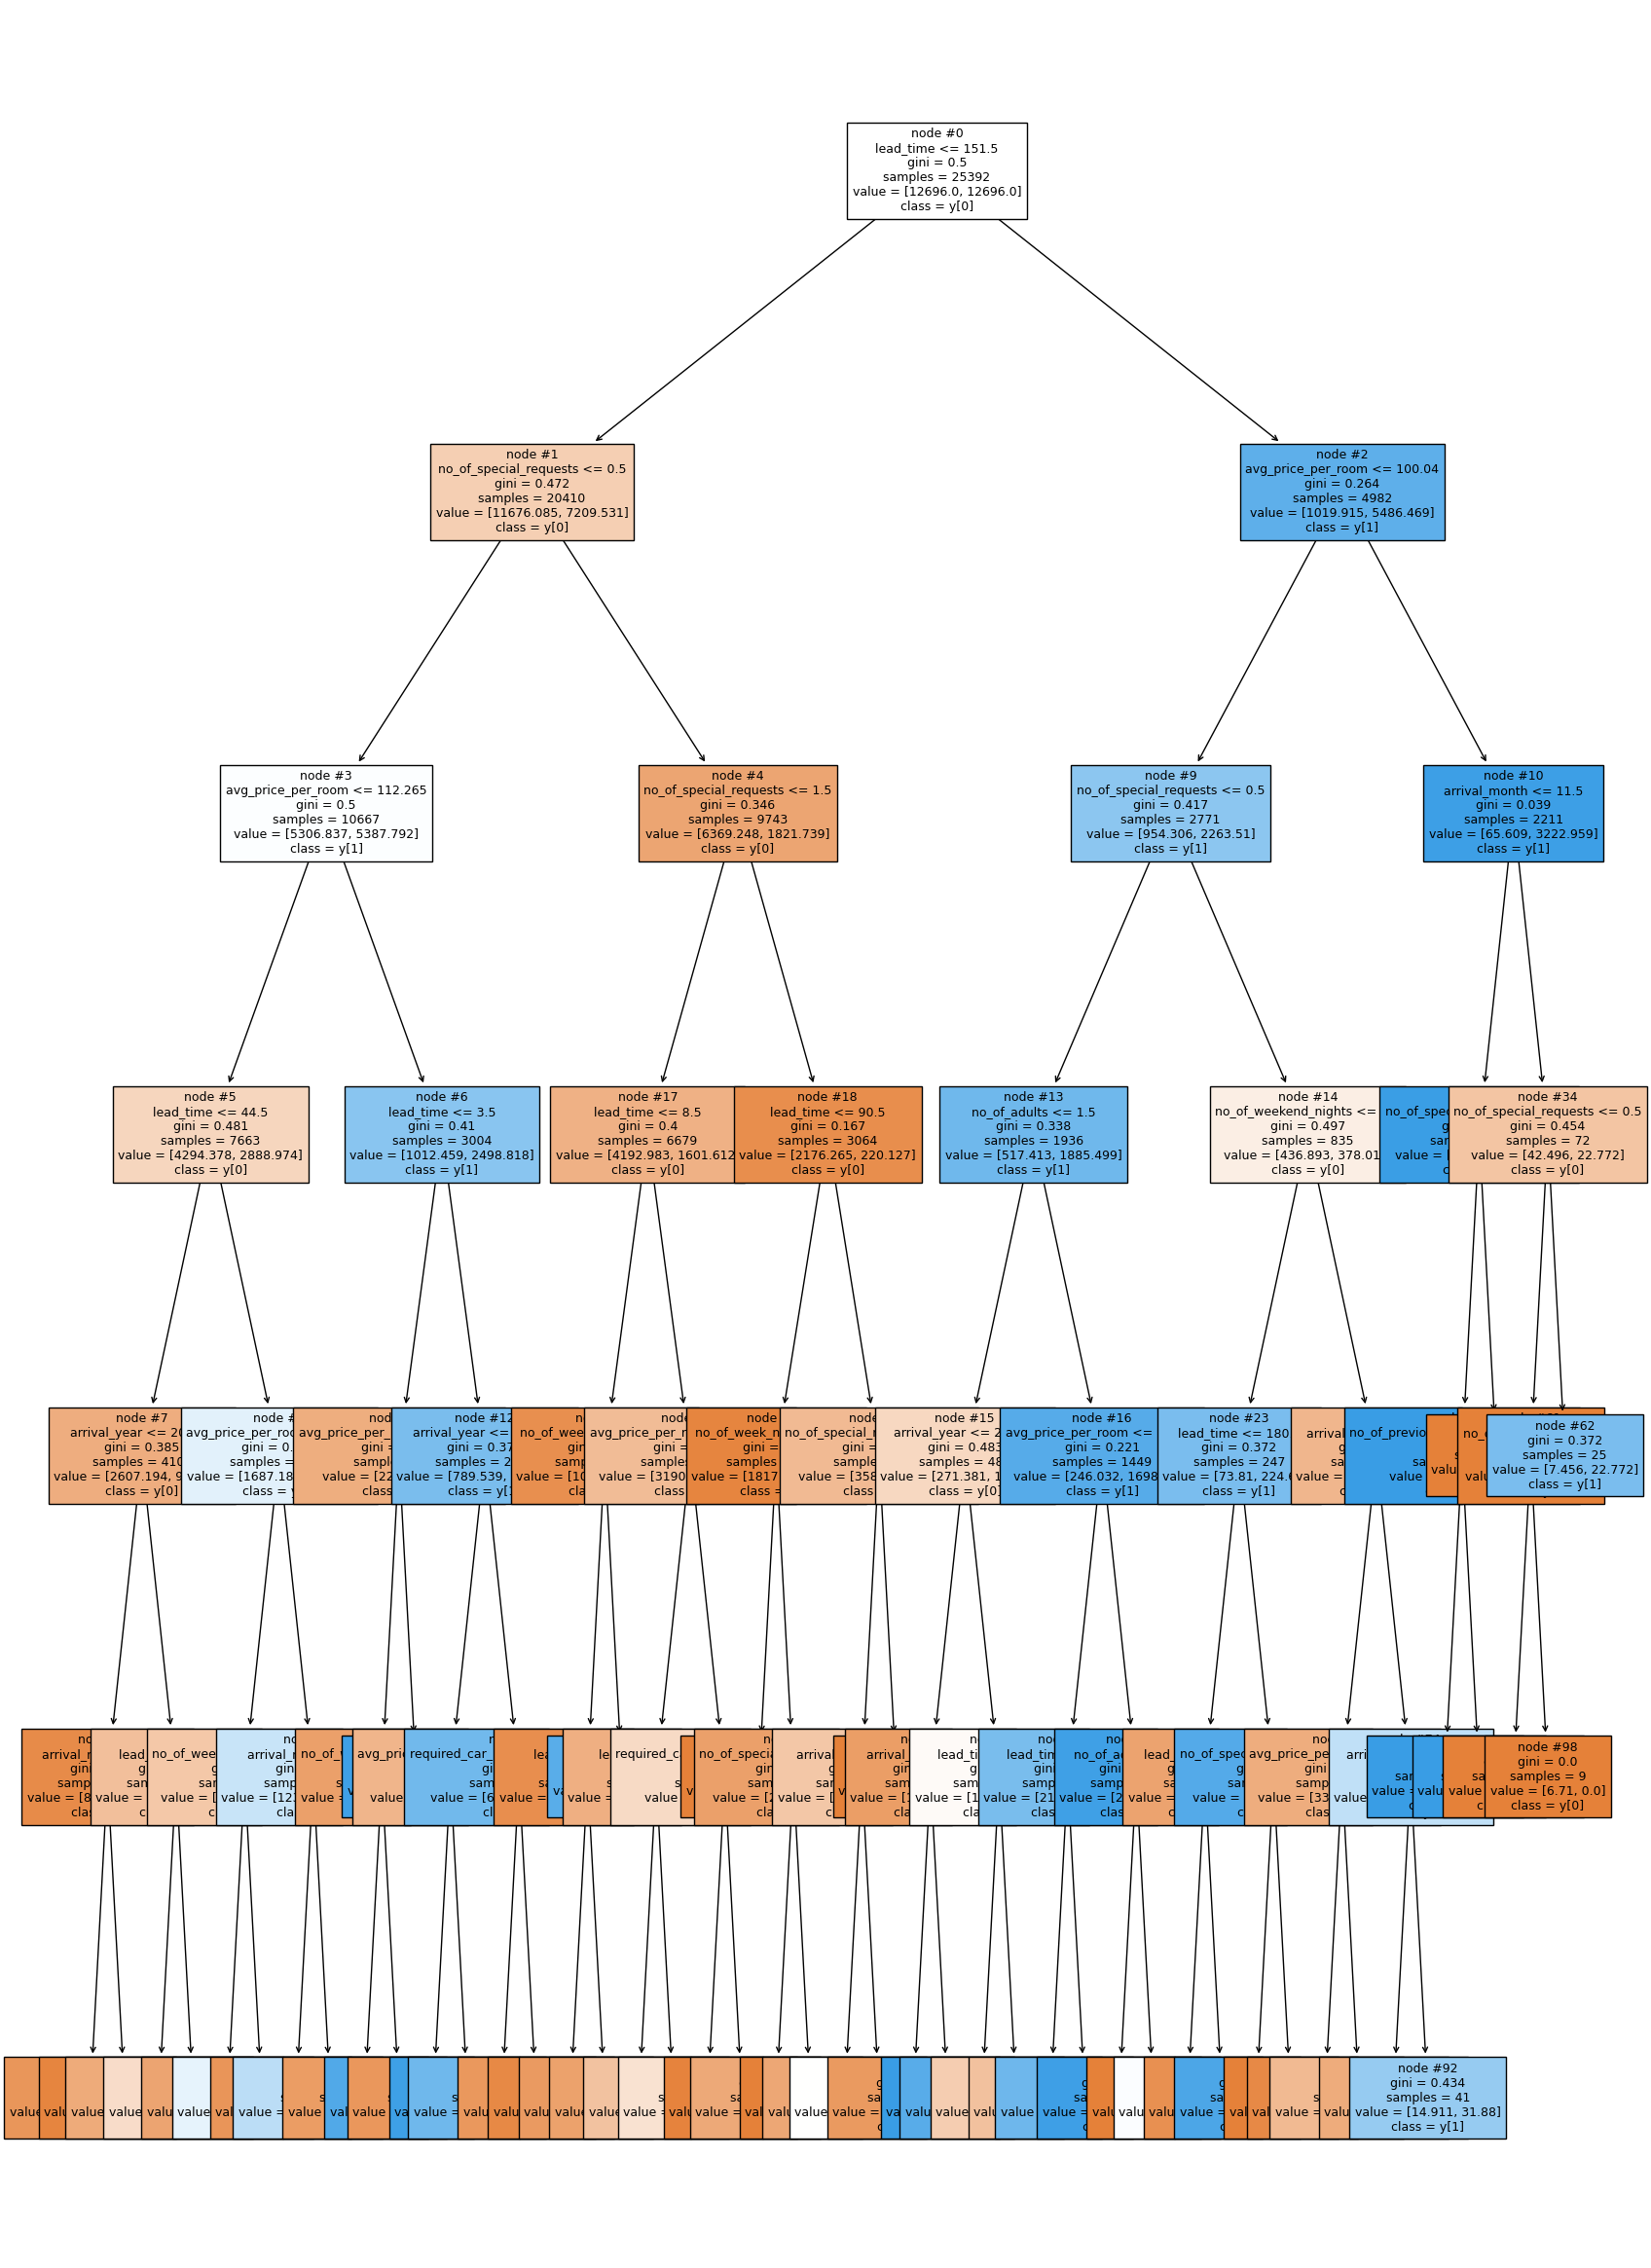

In [ ]:
plt.figure(figsize=(20,30))
tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
print(tree.export_text(estimator, feature_names=feature_names,show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- avg_price_per_room <= 112.26
|   |   |   |--- lead_time <= 44.50
|   |   |   |   |--- arrival_year <= 2017.50
|   |   |   |   |   |--- arrival_month <= 9.50
|   |   |   |   |   |   |--- weights: [323.57, 54.65] class: 0
|   |   |   |   |   |--- arrival_month >  9.50
|   |   |   |   |   |   |--- weights: [567.36, 16.70] class: 0
|   |   |   |   |--- arrival_year >  2017.50
|   |   |   |   |   |--- lead_time <= 14.50
|   |   |   |   |   |   |--- weights: [1011.71, 333.99] class: 0
|   |   |   |   |   |--- lead_time >  14.50
|   |   |   |   |   |   |--- weights: [704.55, 511.60] class: 0
|   |   |   |--- lead_time >  44.50
|   |   |   |   |--- avg_price_per_room <= 72.78
|   |   |   |   |   |--- no_of_weekend_nights <= 1.50
|   |   |   |   |   |   |--- weights: [302.69, 85.01] class: 0
|   |   |   |   |   |--- no_of_weekend_nights >  1.50
|   |   |   |   |   |   |--- weights: [144.64, 165.47] class: 1
|   |   | 

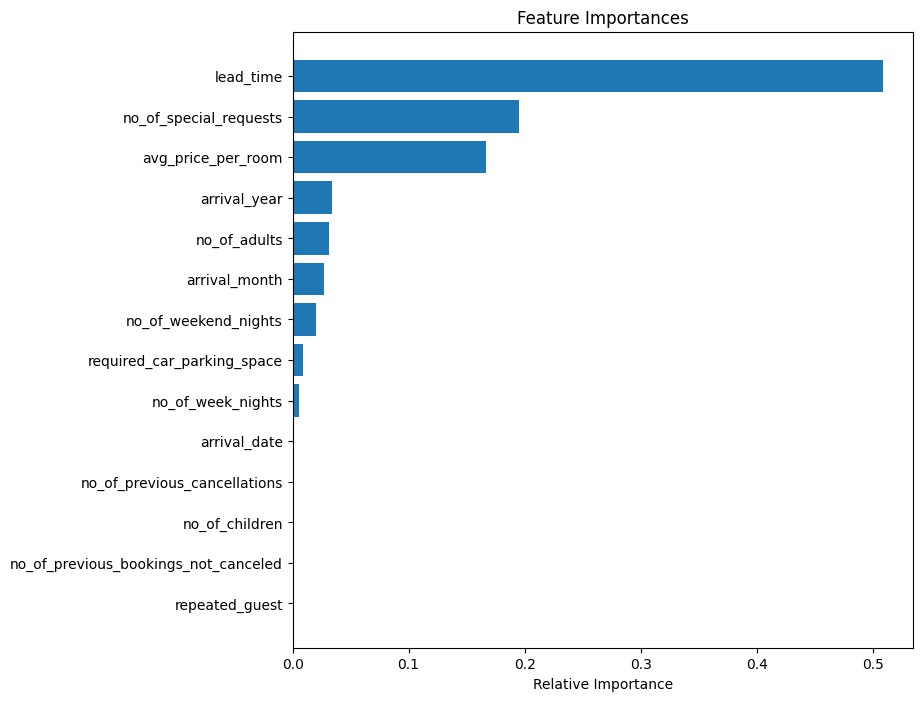

In [ ]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

*   Post-pruning, Lead Time appears to have a significant affect on if a guest cancels.

In [ ]:
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced')
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
pd.DataFrame(path)

ccp_alphas  impurities
0        0.00000     0.00918
1        0.00000     0.00918
2        0.00000     0.00918
3        0.00000     0.00918
4        0.00000     0.00918
...          ...         ...
2074     0.00980     0.36112
2075     0.01099     0.37210
2076     0.01779     0.38990
2077     0.02893     0.41882
2078     0.08118     0.50000

[2079 rows x 2 columns]

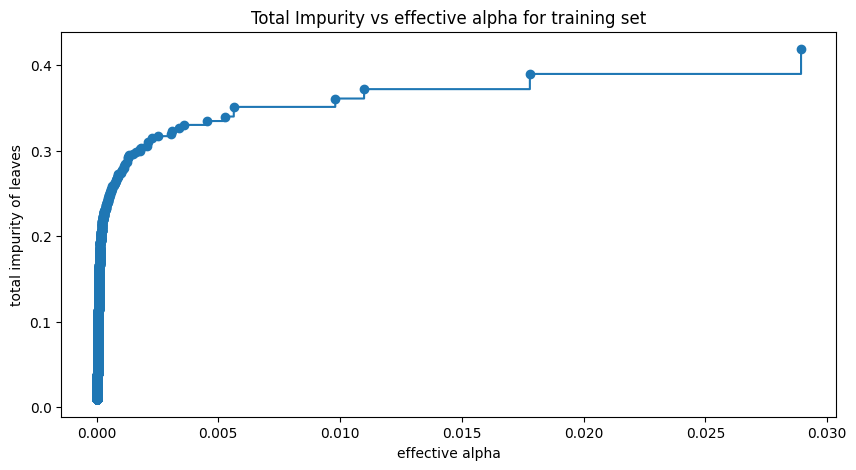

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha, class_weight='balanced')
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08117914389137032


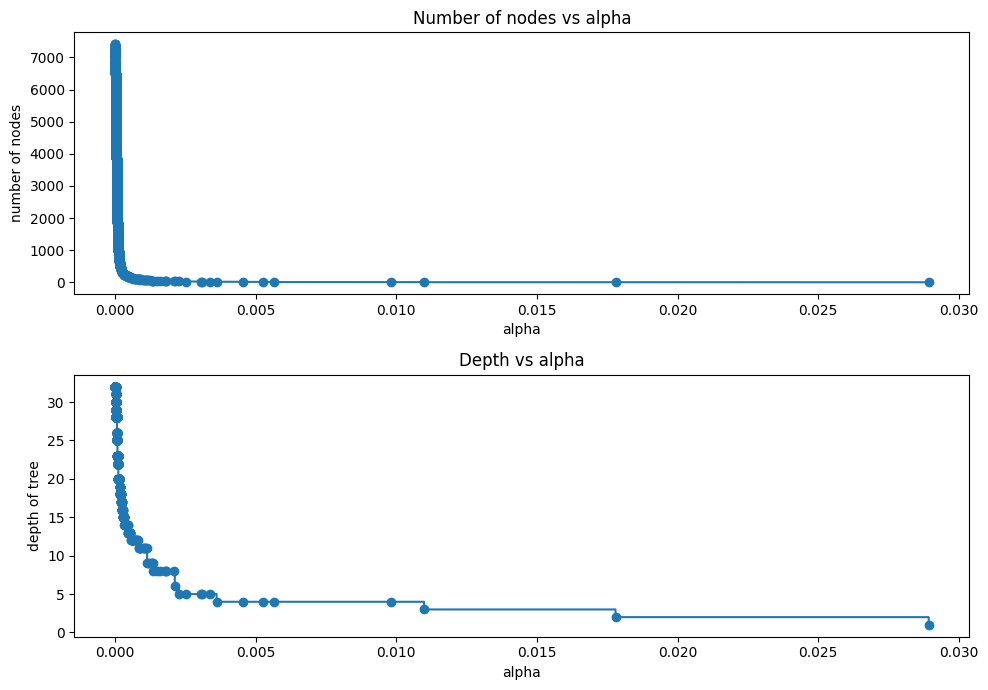

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

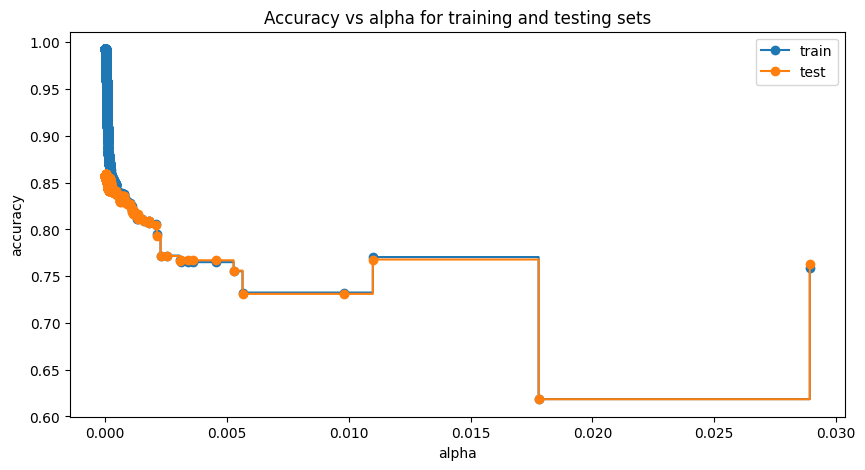

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)
print("Accuracy on training set: ", best_model.score(X_train, y_train))
print("Accuracy on test set: ", best_model.score(X_test, y_test))

DecisionTreeClassifier(ccp_alpha=3.902402540130058e-05, class_weight='balanced',
                       random_state=1)
Accuracy on training set:  0.9777488972904852
Accuracy on test set:  0.8591381053018469


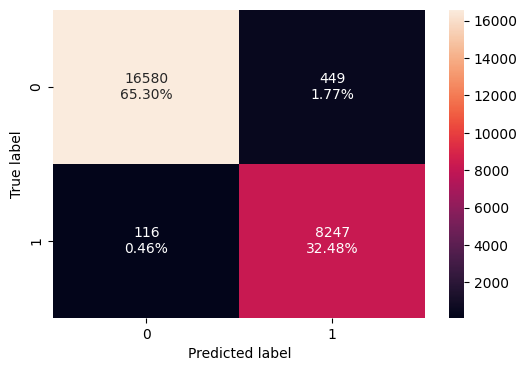

In [ ]:
confusion_matrix_sklearn(best_model, X_train, y_train)

In [ ]:
decision_tree_post_perf_train = model_performance_classification_sklearn(best_model, X_train, y_train)
print("Training performance:")
decision_tree_post_perf_train

Training performance:


Accuracy  Recall  Precision      F1
0   0.97775 0.98613    0.94837 0.96688

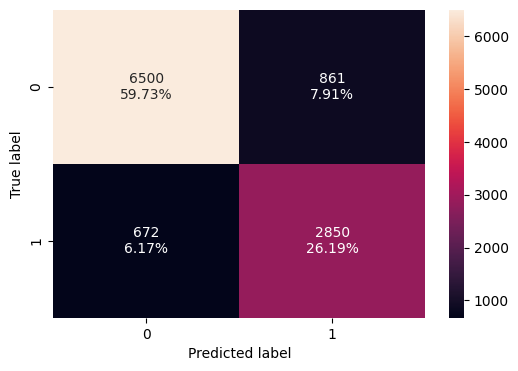

In [ ]:
confusion_matrix_sklearn(best_model, X_test, y_test)

In [ ]:
decision_tree_perf_test = model_performance_classification_sklearn(best_model, X_test, y_test)
print("Test performance:")
decision_tree_perf_test

Test performance:


Accuracy  Recall  Precision      F1
0   0.85914 0.80920    0.76799 0.78805

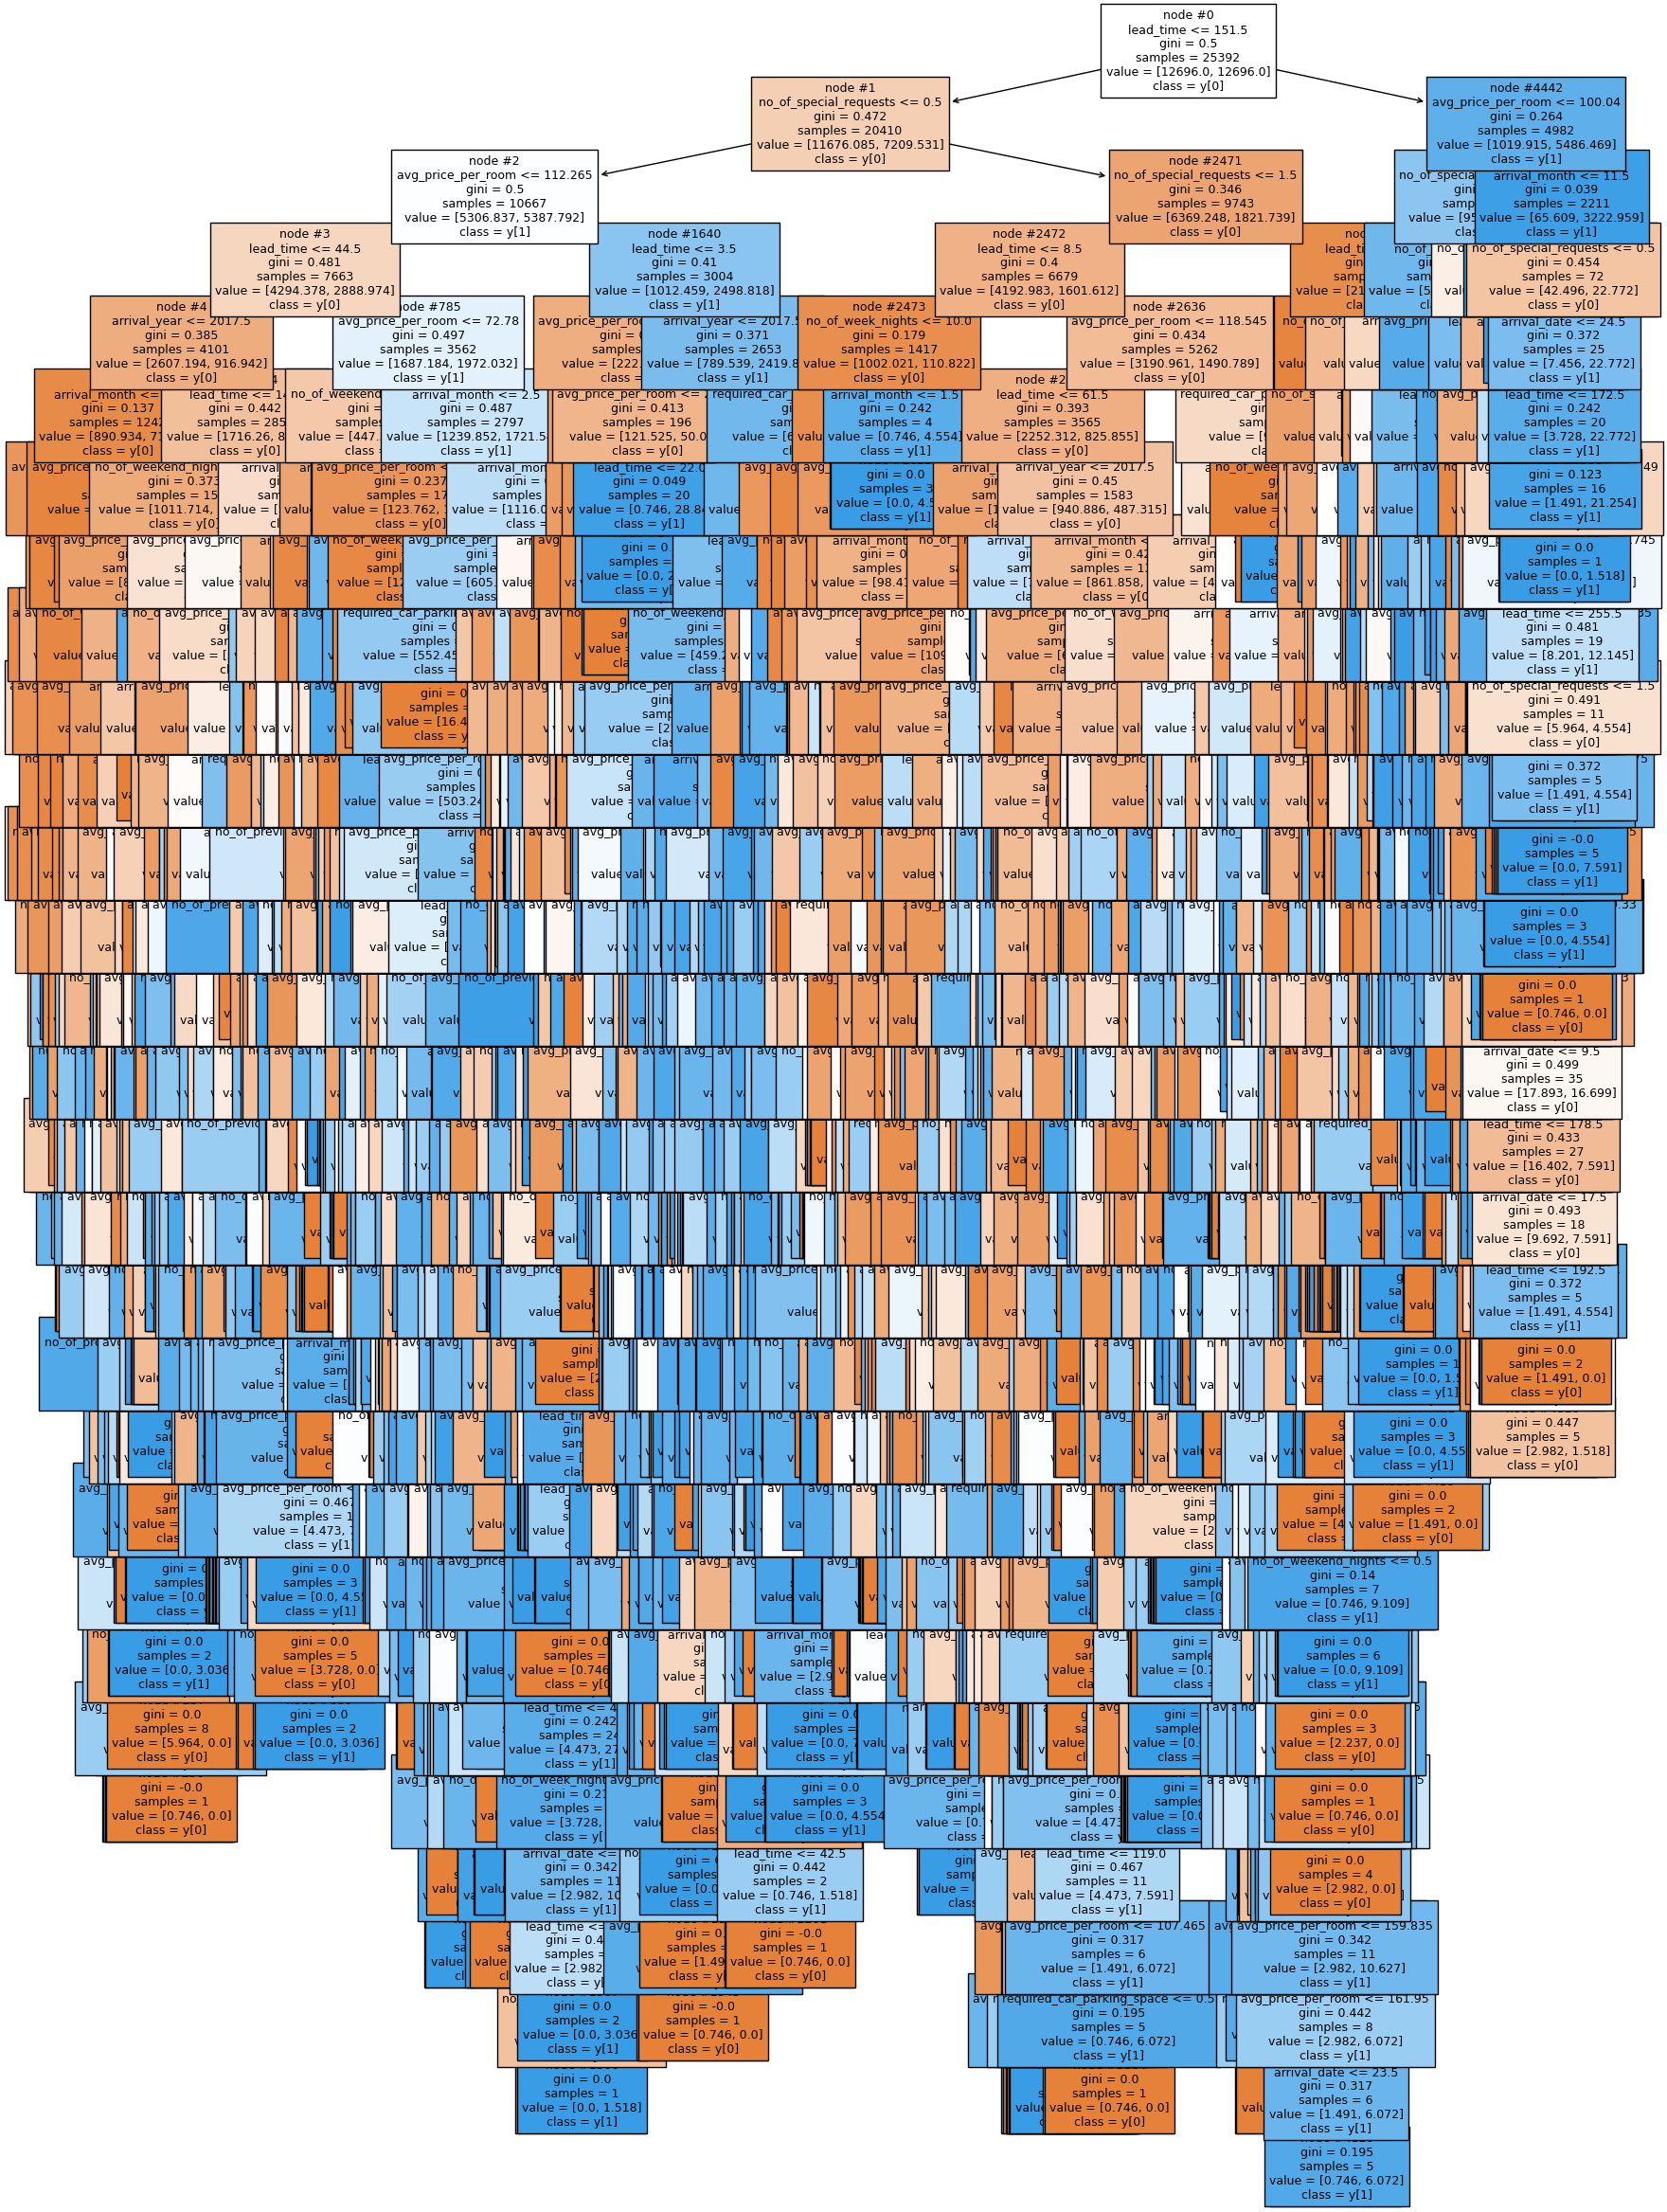

In [ ]:
plt.figure(figsize=(20,30))
tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
print(tree.export_text(best_model,feature_names=feature_names,show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- avg_price_per_room <= 112.26
|   |   |   |--- lead_time <= 44.50
|   |   |   |   |--- arrival_year <= 2017.50
|   |   |   |   |   |--- arrival_month <= 9.50
|   |   |   |   |   |   |--- avg_price_per_room <= 101.19
|   |   |   |   |   |   |   |--- arrival_date <= 9.50
|   |   |   |   |   |   |   |   |--- avg_price_per_room <= 92.10
|   |   |   |   |   |   |   |   |   |--- weights: [59.64, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- avg_price_per_room >  92.10
|   |   |   |   |   |   |   |   |   |--- avg_price_per_room <= 94.75
|   |   |   |   |   |   |   |   |   |   |--- arrival_date <= 4.50
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 3.04] class: 1
|   |   |   |   |   |   |   |   |   |   |--- arrival_date >  4.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- avg_price_per_room >  94.75
|   |   |   |   |   |  

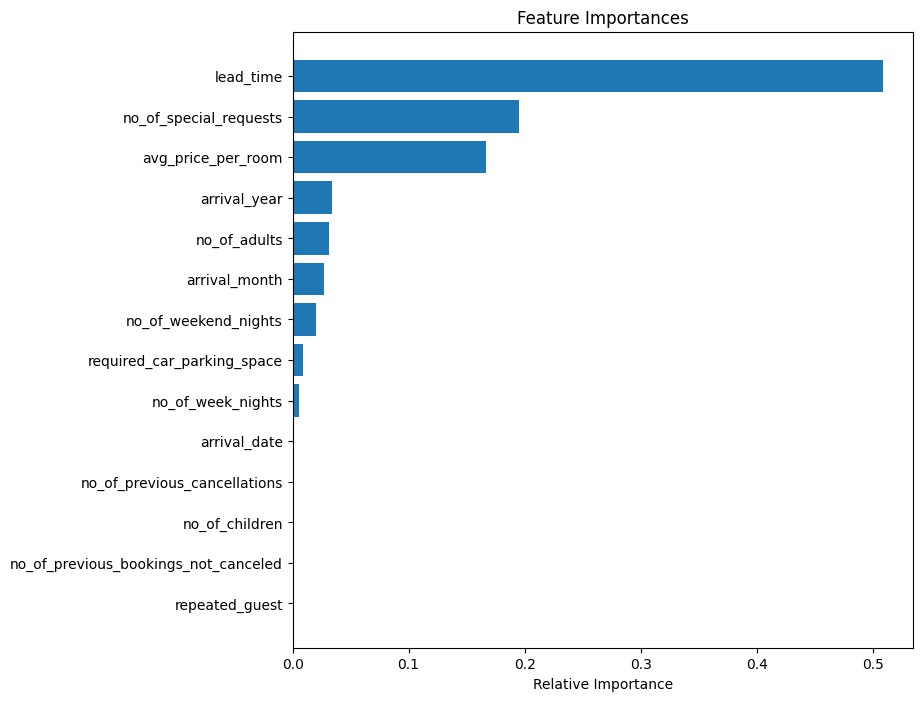

In [ ]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Model Performance Comparison and Conclusions

In [ ]:
models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Decision Tree sklearn  Decision Tree (Pre-Pruning)  \
Accuracy                 0.99354                      0.80328   
Recall                   0.98529                      0.74961   
Precision                0.99505                      0.68364   
F1                       0.99015                      0.71511   

           Decision Tree (Post-Pruning)  
Accuracy                        0.97775  
Recall                          0.98613  
Precision                       0.94837  
F1                              0.96688

## Actionable Insights and Recommendations

- What profitable policies for cancellations and refunds can the hotel adopt?
- What other recommedations would you suggest to the hotel?

* Lead time, the number of special requests, and the average room price are the most important variables in determining if a guest will cancel.
* Offer "last-minute booking" deals to encourage shorter leaad times.
* Guests that have cancelled in their past are more likely to cancel again, therefore, the hotel could give penalties, such as limited room/meal types or non-refundable deposits for 10 or more cancellations.
* As the number of adults on a reservation increases, the likelihood that a guest cancels increases. This could occur due to scheduling comflicts between the adults on one reservation. The hotel could allow discounted rates to decrease room sizes after booking.
* Repeat guests are less likely to cancel their booking. To increase repeat guests, the hotel should offer incentives, such as discount codes or early check-in, to encourage guests to return.
* The hotel could offer a cancellation policy, where guests that cancel a week or more in advance are offered a full refund, guests that cancel 2-6 days are offered a partial refund, and guests that cancel with one day of their reservation do not receive a refund.